# Scratch Notebook : Plankton Recognition Challenge

> $ Group$ $ 3:  $ 
* $ ARRIAU$ $Emma$
* $ LUSCAN$ $ Pierre$
* $ MOSCHINI$ $ Irina$
* $ GUIGA $ $ Chloé $



This challenge, which was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS, aims at developing a model which accurately classify plankton images that has been collected since 2013. In total there are **39 'level2' categories** of plankton, which led us to a **multi-class classification problem**.

Two formats of data were provided : **images** of plankton and **features** manually engineered from these images. We decided to work both on the images (developping a Convolutional Neural Net) and on the features (developping Random Forest model) to compare these two approaches [A COMPLETER : but?].

<br/>

This *scratch notebook* gives a comprehensive overview of our findings. It will be structured in the following way : 

**I. Data Preparation** 

**II. Model Selection**


Remarks : 
- In each section, we imported the latest version of the datasets as it was loaded into the Drive to make everyone of us able to access it. 
- As said earlier, we decided to work both on the extracted features and on the images so the data preparation will be divided into 2 major parts which are data preparation for the features and data preparation for the images.


Let us import the files, the data and the librairies needed for this challenge.

In [0]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg
import seaborn as sns

import cv2
import keras

import keras.backend as K
from PIL import Image
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import VGG16

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#I. DATA PREPARATION

##1. a. Data preparation for the extracted features

reference sites : 
- https://www.seanoe.org/data/00446/55741/ for the native features description
- https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops for the skimage features

As usual, the preparation for the features consisted in: 

- **dataset preparation** where we created a dataset from the combination of the native and skimage features.
- **data visualization** where we explored the _level2_ distribution, which is the target containing the 39 categories.
- **data cleaning** where we removed the samples containing NaN values for the _level2_ feature
- **data pre-processing**

###1. a. 1) Dataset preparation

Let us first import the files that contains the natives features (manually engineered) and the skimage features which are the result of processing the native features with the skimage Python library.

In [0]:
features_native = pd.read_csv('/content/drive/My Drive/Plankton Recognition Challenge/Data/features_native.csv', delimiter=',')
features_skimage = pd.read_csv('/content/drive/My Drive/Plankton Recognition Challenge/Data/features_skimage.csv', delimiter=',')
meta_pd = pd.read_csv('/content/drive/My Drive/Plankton Recognition Challenge/Data/meta.csv', delimiter=',')

_Native features_

In [0]:
features_native.head()

,objid,area,meanimagegrey,mean,stddev,min,perim.,width,height,major,minor,angle,circ.,feret,intden,median,skew,kurt,%area,area_exc,fractal,skelarea,slope,histcum1,histcum2,histcum3,nb1,nb2,nb3,symetrieh,symetriev,symetriehc,symetrievc,convperim,convarea,fcons,thickr,esd,elongation,range,meanpos,centroids,cv,sr,perimareaexc,feretareaexc,perimferet,perimmajor,circex,cdexc,kurt_mean,skew_mean,convperim_perim,convarea_area,symetrieh_area,symetriev_area,nb1_area,nb2_area,nb3_area,nb1_range,nb2_range,nb3_range,median_mean,median_mean_range,skeleton_area
0,32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,132.0,90,0.138,128.8,3153711.0,253,-0.804,-1.142,94.71,352.0,1.012,15327.0,0.802,100,146,238,3,3,10,1.431,1.430,3,3,15327.0,15327.0,253.107,1.008,106,1.121212,170,-0.404959,4,31.553398,38.235294,2.215909,0.366477,6.046512,5.270270,5.656474,0.011364,-0.004854,-0.004854,19.650000,91.778443,0.005988,0.005988,0.017964,0.017964,0.059880,0.017647,0.017647,0.058824,47,0.276471,91.778443
1,32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,46.3,90,0.458,67.2,701229.0,255,-1.903,2.434,68.31,404.0,1.026,2993.0,0.110,167,216,246,4,2,1,1.657,1.646,3,2,2993.0,2993.0,31.693,1.014,104,1.782609,157,-0.154412,-1,16.666667,24.840764,0.462871,0.165842,2.791045,2.280488,27.442236,-0.002475,0.008547,-0.008547,16.005348,18.030120,0.012048,0.012048,0.024096,0.012048,0.006024,0.025478,0.012739,0.006369,21,0.133758,18.030120
2,32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,38.4,90,0.398,115.6,1000126.0,255,-2.147,5.385,65.60,831.0,1.050,4182.0,0.183,205,229,243,2,9,18,2.799,2.769,4,4,4182.0,4182.0,63.590,1.008,106,3.657895,161,-0.110345,-1,10.878661,16.149068,0.332130,0.139591,2.379310,1.985612,37.563504,-0.001203,0.020921,-0.008368,15.152174,24.892857,0.017857,0.017857,0.011905,0.053571,0.107143,0.012422,0.055901,0.111801,16,0.099379,24.892857
3,32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,141.0,0,0.119,171.3,4167272.0,255,-4.124,17.007,100.00,0.0,1.185,16594.0,1.607,251,252,253,0,0,4,1.344,1.353,9,9,16245.0,15317.0,281.337,1.872,106,1.070922,148,-0.042254,-1,8.433735,14.189189,NaN,NaN,2.269006,2.569536,0.000000,NaN,0.068273,-0.016064,41.868557,91.718563,0.005988,0.005988,0.000000,0.000000,0.023952,0.000000,0.000000,0.027027,6,0.040541,99.365269
4,32760598.0,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,83.5,90,0.037,244.4,4577141.0,255,-4.376,20.118,95.82,69.0,1.013,18278.0,1.825,242,251,252,5,14,10,2.612,2.598,19,19,18278.0,18278.0,285.249,1.004,106,3.321429,131,-0.039683,4,6.000000,11.450382,10.898551,3.536232,3.081967,2.695341,1.149973,0.057971,0.080000,-0.016000,24.305851,109.449102,0.017964,0.017964,0.029940,0.083832,0.059880,0.038168,0.106870,0.076336,5,0.038168,109.449102


In [0]:
features_native.shape

(243610, 65)

- The images we have at hand were processed with ZooProcess which generated regions of interest (ROIs) around each individual object (plankton) and a set of associated native features measured on the object.
- There are **64 native features** (we don't count the objid)  which correspond to various characteristics of the samples such as the **_area_** which is the surface area of the object in square pixels, **_mean_** which is the average grey value within the object, **_width_** and **_height_** which contains the width and height of the smallest rectangle enclosing the object, etc. 
- We can notice that there is **only numerical** features. 

_Skimage features_

In [0]:
features_skimage.head()

,objid,area,convex_area,eccentricity,equivalent_diameter,euler_number,filled_area,inertia_tensor0,inertia_tensor1,inertia_tensor2,inertia_tensor3,inertia_tensor_eigvals0,inertia_tensor_eigvals1,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,moments_hu0,moments_hu1,moments_hu2,moments_hu3,moments_hu4,moments_hu5,moments_hu6,moments_normalized0,moments_normalized1,moments_normalized2,moments_normalized3,moments_normalized4,moments_normalized5,moments_normalized6,moments_normalized7,moments_normalized8,moments_normalized9,moments_normalized10,moments_normalized11,moments_normalized12,moments_normalized13,moments_normalized14,moments_normalized15,perimeter,solidity,weighted_moments_hu0,weighted_moments_hu1,weighted_moments_hu2,weighted_moments_hu3,weighted_moments_hu4,weighted_moments_hu5,weighted_moments_hu6,weighted_moments_normalized0,weighted_moments_normalized1,weighted_moments_normalized2,weighted_moments_normalized3,weighted_moments_normalized4,weighted_moments_normalized5,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15
0,32588204.0,1280.0,1847.0,0.998732,40.370120,1,1280.0,101.683506,-457.457683,-457.457683,2188.058007,2283.952480,5.789033,191.162862,212,116.007031,15,9.624164,1.788861e+09,3.167742e+09,4.377962e+07,4.356361e+07,1.902487e+06,7.748445e+07,-9.677889e+02,NaN,NaN,1.709420e+09,1.979126e+08,NaN,3.573888e+08,3.783747e+07,1.092249e+09,7.944024e+07,7.107486e+06,2.312424e+08,4.799611e+07,1.282568e+06,5.079978e+07,8.205139e+06,1.789964e+08,370.308658,0.693016,1.162088e+07,1.337083e+05,366.852215,365.936978,1.340772e-04,4.231037,2.637547e-09,NaN,NaN,1.110026e+07,564474.767483,NaN,2.333442e+06,122988.160150,59341.570582,5.206276e+05,26602.640746,12729.157425,1547.426179,5.714891e+03,2.803411e+03,328.453206,99.648803
1,32718824.0,1344.0,2245.0,0.695802,41.367064,-3,1456.0,205.937964,-25.679712,-25.679712,116.629881,212.795388,109.772457,58.350032,228,141.321429,18,41.908941,2.400058e+08,5.875831e+06,1.830597e+06,1.167258e+05,-8.101917e-01,8.925805e+03,5.395078e+01,NaN,NaN,8.677818e+07,4.267646e+06,NaN,1.910693e+07,-1.097790e+07,1.500691e+06,1.532277e+08,-7.416746e+06,1.203019e+07,-1.820004e+05,6.430596e+05,8.965769e+06,-3.175089e+06,8.144953e+05,373.711724,0.598664,1.505197e+06,2.213928e+02,0.557189,0.005462,2.034996e-14,0.000003,-3.006444e-13,NaN,NaN,5.824171e+05,1498.745318,NaN,1.624393e+05,-5333.640261,100.818064,9.227797e+05,-460.571019,479.826559,1.421619,7.427521e+03,3.060606e+02,-5.929098,0.174156
2,32741900.0,7728.0,13024.0,0.909170,99.194734,-14,7867.0,343.887100,-101.515634,-101.515634,1939.555844,1945.988287,337.454657,176.453429,244,197.906573,21,73.479756,2.954766e+08,4.332375e+07,5.493681e+06,4.609978e+06,2.302411e+04,9.557840e+05,2.847874e+03,NaN,NaN,2.509777e+08,-6.879093e+07,NaN,1.313608e+07,-5.493509e+06,1.999564e+07,4.449885e+07,1.286178e+06,7.606430e+06,-3.737676e+06,-1.792541e+06,1.055530e+06,-5.747321e+05,1.334290e+06,1118.993037,0.593366,1.228222e+06,6.901847e+02,0.472152,0.408031,1.778293e-10,0.000339,2.124288e-11,NaN,NaN,1.027963e+06,-20560.974718,NaN,3.567109e+04,-413.769431,278.171044,2.002588e+05,386.091691,130.204406,-4.194633,-5.886338e+02,1.774976e+01,-0.462406,0.090115
3,32646541.0,1062.0,1913.0,0.848934,36.772006,-7,1205.0,148.677328,-97.739826,-97.739826,221.814748,289.602850,80.889227,68.070887,222,95.559322,21,35.975375,3.488626e+08,3.862358e+07,6.744908e+06,1.681602e+06,5.075533e+03,2.219646e+05,2.512454e+03,NaN,NaN,2.088651e+08,1.707283e+06,NaN,9.203373e+07,-1.914331e+07,3.291259e+07,1.399975e+08,-2.304393e+07,3.451087e+07,-1.002397e+07,-1.587596e+07,3.173487e+07,-1.131843e+07,1.179997e+07,561.949314,0.555149,3.372039e+06,3.680781e+03,6.831320,2.920514,1.272531e-08,0.005012,2.869901e-09,NaN,NaN,2.039149e+06,-

In [0]:
features_skimage.shape

(243610, 66)

- Concerning the skimage features, they were obtained by processing the native features with the scikit-image toolbox (more precisely the skimage.measure.regionprops function) which resulted in **65 features** (again we don't count the objid).
- For example, amongst the features computed with regionpros function we can find several **_weighted_moments_normalized_** which are normalized moments (translation and scale invariant) of intensity image up and **_moments_hu** which are Hu moments (translation, scale and rotation invariant), etc.
- As well as the native features, that there is **only numerical** features. 

_Meta_

In [0]:
meta_pd.head()

,objid,projid,id,status,latitude,longitude,objdate,objtime,depth_min,depth_max,unique_name,lineage,level1,level2
0,32756761.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
1,32759364.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
2,32758055.0,133,28299,V,43.683333,7.3,2013-09-19,00:09:00,0,75,Guinardia,/#/living/Eukaryota/Harosa/Stramenopiles/Ochro...,Guinardia,Rhizosolenids
3,32758988.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks
4,32760598.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks


This file is important because it contains the **index of images** and their corresponding **level2 labels**. 

So far we have seen that we have access to 3 datasets with different pieces of information in each so we decide to **join the 3 datasets**. Why choosing both native and skimage features to train our models ? Well, in order to have both the information contained in the native and in the skimage we want to keep these 2 tables even if we know that there may be a redundancy of information given that skimages features from native features. This is why we will try a Principal Components Analysis **(PCA)** to reduce the number of features we will use to train our model. 

Remark : both native and skimage datasets contains an _area_ feature, we will keep only one of them. Indeed, they respectively represent the area of the object and the ROI which is really similar so even if the two columns does not have the same values, they are really close and keeping the two features makes little sense.

In [0]:
inter = features_native.set_index('objid').join(features_skimage.set_index('objid'),lsuffix='_native', rsuffix='_skimage')
inter.head()

,area_native,meanimagegrey,mean,stddev,min,perim.,width,height,major,minor,angle,circ.,feret,intden,median,skew,kurt,%area,area_exc,fractal,skelarea,slope,histcum1,histcum2,histcum3,nb1,nb2,nb3,symetrieh,symetriev,symetriehc,symetrievc,convperim,convarea,fcons,thickr,esd,elongation,range,meanpos,...,moments_normalized1,moments_normalized2,moments_normalized3,moments_normalized4,moments_normalized5,moments_normalized6,moments_normalized7,moments_normalized8,moments_normalized9,moments_normalized10,moments_normalized11,moments_normalized12,moments_normalized13,moments_normalized14,moments_normalized15,perimeter,solidity,weighted_moments_hu0,weighted_moments_hu1,weighted_moments_hu2,weighted_moments_hu3,weighted_moments_hu4,weighted_moments_hu5,weighted_moments_hu6,weighted_moments_normalized0,weighted_moments_normalized1,weighted_moments_normalized2,weighted_moments_normalized3,weighted_moments_normalized4,weighted_moments_normalized5,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15
objid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,132.0,90,0.138,128.8,3153711.0,253,-0.804,-1.142,94.71,352.0,1.012,15327.0,0.802,100,146,238,3,3,10,1.431,1.430,3,3,15327.0,15327.0,253.107,1.008,106,1.121212,170,-0.404959,...,NaN,1.279746e+08,2.231306e+07,NaN,2.719131e+07,-7.213529e+06,5.430433e+06,9.207304e+07,-7.823094e+06,9.849355e+06,2.387593e+05,2.163625e+06,3.671610e+06,-1.423642e+06,6.063819e+05,1050.714862,0.628077,1.086257e+06,141.981496,0.328274,0.045152,5.380579e-12,-1.682703e-07,-1.125877e-12,NaN,NaN,6.014419e+05,9.325868e+03,NaN,1.791506e+05,-1525.763412,194.164325,4.848153e+05,-2694.631449,241.440457,1.295103,440.053063,129.297892,-2.122403,0.115495
32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,46.3,90,0.458,67.2,701229.0,255,-1.903,2.434,68.31,404.0,1.026,2993.0,0.110,167,216,246,4,2,1,1.657,1.646,3,2,2993.0,2993.0,31.693,1.014,104,1.782609,157,-0.154412,...,NaN,3.122857e+08,3.873429e+06,NaN,-5.680386e+07,3.288071e+06,-3.626536e+07,8.190202e+07,-8.713215e+06,2.221631e+07,-4.622357e+06,-8.735667e+06,-7.377503e+06,-3.434297e+05,-3.928709e+06,338.663997,0.571333,3.302787e+06,5701.726921,0.905013,0.112204,-1.375254e-11,-1.946467e-04,3.300476e-11,NaN,NaN,2.728961e+06,8.736413e+03,NaN,-5.140816e+05,-2060.928571,-2790.422168,5.738257e+05,-7088.333306,1420.614154,-17.330565,-8402.726309,-335.688243,-11.030494,-1.784313
32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,38.4,90,0.398,115.6,1000126.0,255,-2.147,5.385,65.60,831.0,1.050,4182.0,0.183,205,229,243,2,9,18,2.799,2.769,4,4,4182.0,4182.0,63.590,1.008,106,3.657895,161,-0.110345,...,NaN,8.397750e+08,-1.646830e+08,NaN,-2.097927e+07,9.473912e+06,-3.281929e+07,3.779421e+07,-3.581400e+06,3.041981e+07,-9.421348e+06,1.647676e+06,-3.332623e+06,2.087634e+06,-4.829305e+06,867.416306,0.537051,1.220825e+07,125828.923009,76.795145,84.364545,6.789266e-06,9.448652e-01,-1.335473e-07,NaN,NaN,1.170246e+07,-2.859165e+05,NaN,-3.403948e+05,14954.527800,-6573.884976,5.057891e+05,-4044.999299,5357.163117,-175.738886,1982.197147,-585.246490,36.387240,-11.036476
32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,141.0,0,0.119,171.3,4167272.0,255,-4.124,17.007,100.00,0.0,1.185,16594.0,1.607,251,252,253,0,0,4,1.344,1.353,9,9,16245.0,15317.0,281.337,1.872,106,1.070922,148,-0.042254,...,NaN,6.549735e+08,-2.556928e+07,NaN,7.142228e+08,-9.617200e+07,9.277311e+08,8.034397e+08,-1.821978e+08,1.036359e+09,-2.851636e+08,-2.855829e+08,1.176318e+09,-4.614650e+08,1.829032e+09,402.315801,0.584659,1.182985e+07,136032.303030,371.384959,322.572749,1.116296e-04,3.612542e+00,2.067509e-06,NaN,NaN,5.341701e+06,-9.034729e+04,NaN,5.803403e+06,-152593.712044,

In [0]:
dataset = inter.join(meta_pd.set_index('objid'))
dataset.head()

,area_native,meanimagegrey,mean,stddev,min,perim.,width,height,major,minor,angle,circ.,feret,intden,median,skew,kurt,%area,area_exc,fractal,skelarea,slope,histcum1,histcum2,histcum3,nb1,nb2,nb3,symetrieh,symetriev,symetriehc,symetrievc,convperim,convarea,fcons,thickr,esd,elongation,range,meanpos,...,moments_normalized14,moments_normalized15,perimeter,solidity,weighted_moments_hu0,weighted_moments_hu1,weighted_moments_hu2,weighted_moments_hu3,weighted_moments_hu4,weighted_moments_hu5,weighted_moments_hu6,weighted_moments_normalized0,weighted_moments_normalized1,weighted_moments_normalized2,weighted_moments_normalized3,weighted_moments_normalized4,weighted_moments_normalized5,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15,projid,id,status,latitude,longitude,objdate,objtime,depth_min,depth_max,unique_name,lineage,level1,level2
objid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,132.0,90,0.138,128.8,3153711.0,253,-0.804,-1.142,94.71,352.0,1.012,15327.0,0.802,100,146,238,3,3,10,1.431,1.430,3,3,15327.0,15327.0,253.107,1.008,106,1.121212,170,-0.404959,...,-1.423642e+06,6.063819e+05,1050.714862,0.628077,1.086257e+06,141.981496,0.328274,0.045152,5.380579e-12,-1.682703e-07,-1.125877e-12,NaN,NaN,6.014419e+05,9.325868e+03,NaN,1.791506e+05,-1525.763412,194.164325,4.848153e+05,-2694.631449,241.440457,1.295103,440.053063,129.297892,-2.122403,0.115495,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,46.3,90,0.458,67.2,701229.0,255,-1.903,2.434,68.31,404.0,1.026,2993.0,0.110,167,216,246,4,2,1,1.657,1.646,3,2,2993.0,2993.0,31.693,1.014,104,1.782609,157,-0.154412,...,-3.434297e+05,-3.928709e+06,338.663997,0.571333,3.302787e+06,5701.726921,0.905013,0.112204,-1.375254e-11,-1.946467e-04,3.300476e-11,NaN,NaN,2.728961e+06,8.736413e+03,NaN,-5.140816e+05,-2060.928571,-2790.422168,5.738257e+05,-7088.333306,1420.614154,-17.330565,-8402.726309,-335.688243,-11.030494,-1.784313,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,38.4,90,0.398,115.6,1000126.0,255,-2.147,5.385,65.60,831.0,1.050,4182.0,0.183,205,229,243,2,9,18,2.799,2.769,4,4,4182.0,4182.0,63.590,1.008,106,3.657895,161,-0.110345,...,2.087634e+06,-4.829305e+06,867.416306,0.537051,1.220825e+07,125828.923009,76.795145,84.364545,6.789266e-06,9.448652e-01,-1.335473e-07,NaN,NaN,1.170246e+07,-2.859165e+05,NaN,-3.403948e+05,14954.527800,-6573.884976,5.057891e+05,-4044.999299,5357.163117,-175.738886,1982.197147,-585.246490,36.387240,-11.036476,133,28299,V,43.683333,7.3,2013-09-19,00:09:00,0,75,Guinardia,/#/living/Eukaryota/Harosa/Stramenopiles/Ochro...,Guinardia,Rhizosolenids
32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,141.0,0,0.119,171.3,4167272.0,255,-4.124,17.007,100.00,0.0,1.185,16594.0,1.607,251,252,253,0,0,4,1.344,1.353,9,9,16245.0,15317.0,281.337,1.872,106,1.070922,148,-0.042254,...,-4.614650e+08,1.829032e+09,402.315801,0.584659,1.182985e+07,136032.303030,371.384959,322.572749,1.116296e-04,3.612542e+00,2.067509e-06,NaN,NaN,5.341701e+06,-9.034729e+04,NaN,5.803403e+06,-152593.712044,69665.082779,6.488148e+06,-227827.736082,78598.184534,-4117.231070,-317871.379287,89887.970505,-5606.440604,1325.968409,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks
32760598.0,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,83.5,90,0.037,244.4,4577141.0,255,-4.376,20.118,95.82,69.0,1.013,18278.0,1.825,242,251,252,5,14,10,2.612,2.598,19,19,18278.0,18278.0,285.249,1.004,106,3.32142

In [0]:
#removing the features that are not inherent characteristics

dataset = dataset.drop(columns=['projid','id','status',	'latitude','longitude','objdate','objtime',	'depth_min',	'depth_max',	'unique_name',	'lineage',	'level1'	])
dataset = dataset.drop(columns=['area_skimage'])

dataset.shape

(243610, 129)

We obtain **128 features** and the level2 categories that we want to predict.

###1. a. 2) Data visualization

In this part, we will focus on the **statistics** of the dataset such as the _level2_ distribution.

In [0]:
lev2_distrib = pd.DataFrame(dataset['level2'].value_counts())

lev2_distrib

,level2
detritus,138439
feces,26936
Neoceratium,14014
nauplii (Crustacea),9293
badfocus (artefact),7848
silks,5629
Copepoda,5141
Thalassionema,5117
rods,4044
multiple (other),3261


In [0]:
lev2_distrib.shape

(39, 1)

There a **39 different _level2_ categories** which we will use to classify the planktons of our dataset. At first sight, it seems that there is a lot of detritus in our dataset and some classes are clearly under representated such as Bacteriastrum or Xystonellidae planktons.

AxesSubplot(0.125,0.125;0.775x0.755)


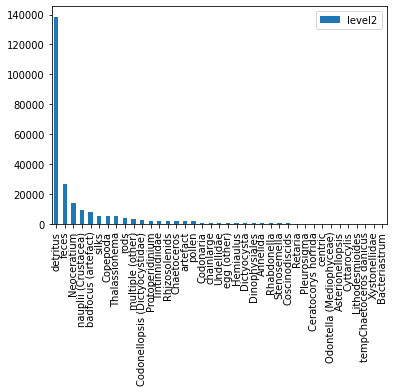

In [0]:
f = lev2_distrib.plot.bar()
print(f)

Indeed, we can clearly notice that our dataset is **sharply unbalanced** due to a high number of samples with the label 'detritus' compared to the other categories. This can be a problem because [A COMPLETER]. We will handle this problem with **data augmentation** by oversampling the classes that are under representated in the section 1. b. 3) Data augmentation.


###1. a. 3) Data cleaning

This section will essentially deal with the treatment of **NaN values** wheteher for the input features or the target feature (namely the label) _level2_.

In [0]:
print((dataset['level2'].isnull().sum()))

1003


First we want to know the number of samples for which the _level2_ label is a NaN value. It seems that it concerns **1003 samples**. We delete these rows on out dataset because we cannot train a model on them.

In [0]:
index_to_drop = dataset[dataset['level2'].isnull()].index
dataset = dataset.drop(index=index_to_drop)

Now let us move to the features in the dataset that contains NaN values.

In [0]:
pd.DataFrame(dataset.isnull().sum())

,0
area_native,0
meanimagegrey,0
mean,0
stddev,0
min,0
perim.,0
width,0
height,0
major,0
minor,0


There are only NaN values in moments_normalized0 , moments_normalized1 , moments_normalized4 , weighted_moments_normalized0 , weighted_moments_normalized1 , weighted_moments_normalized4. We need to know if these features are correlated with the target variable in order to determine if we can delete these features or not. [A COMPLETER]

###1. a. 4) Data pre-processing

Preprocessing ? (feature selection)

##1. b. Data preparation for the images

Some further steps were needed to prepare the images after having obtained some information from the data preparation for the extracted features. We prepared the images through :
- **data exploration** where we explored images dimensions and their number of channels.
- **data cleaning** where we deleted the samples containing NaN values for the level2 feature and that were "too small" to be processed by a CNN. We also associated the level2 labels to the images. (NB : the "too small" threshold is explained later on).
- **data augmentation** where we performed oversampling on the classes that lacked samples by applying some transformations to the existing images (rotation, flip, luminosity modification). 


###1. b. 1) Data exploration

In this section, we focus on the shapes of the images, their distribution to be able to clean the data in the next section.

First let us import the images.

In [0]:
# importing the imoages

input_zip = '/content/drive/My Drive/Plankton Recognition Challenge/Data/imgs.zip'
img_files = extract_zip_to_memory(input_zip)
names_img = [name for name in img_files]

# converting images in numpy arrays

array_img = [np.array(Image.open(img_files[names_img[i]])) for i in range (len(names_img))]

Now that the pictures are transformed into arrays, let's have a look at random pictures of our dataset.

Dimension of the 1st image displayed (73, 67)


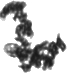

Dimension of the 2nd image displayed (25, 17)


Dimension of the 3rd image displayed (242, 263)


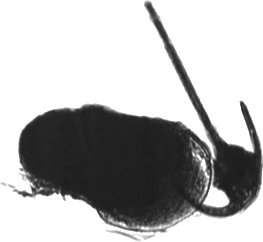

In [0]:
print('Dimension of the 1st image displayed', np.shape(array_img[100]))
cv2_imshow(array_img[100])

print('Dimension of the 2nd image displayed', np.shape(array_img[101]))
cv2_imshow(array_img[101])

print('Dimension of the 3rd image displayed', np.shape(array_img[102]))
cv2_imshow(array_img[102])

We can see that the three images we displayed have only one canal, let us check if it the case for all the images. Moreover, the sizes of these images are very different. Let's have a look at the dimensions of all the images.

In [0]:
heights = []
widths = []
no_2d_img = []
nber_of_channels=[]

for i in range(len(names_img)):
  shape_i = np.shape(array_img[i])
  heights.append(shape_i[0])  
  widths.append(shape_i[1])
  nber_of_channels.append(len(img.getbands()))
  if np.shape(shape_i) != (2,):
    no_2d_img.append(names_img[i])
    print(names_img[i], 'has more than 2 dimension')

In [0]:
print('Maximum height:', max(heights))
print('Minimum height:', min(heights), '\n')

print('Maximum width:', max(widths))
print('Minimum width:', min(widths))

Maximum height: 739
Minimum height: 2 

Maximum width: 972
Minimum width: 2


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Distribution of the number of channels of the images')

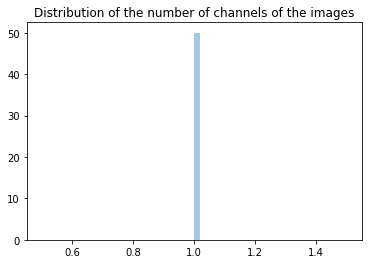

In [0]:
sns.distplot(nber_of_channels)
plt.title('Distribution of the number of channels of the images')

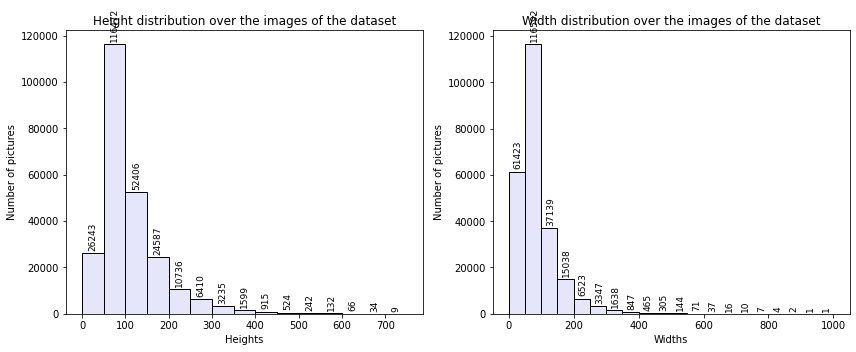

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].hist(heights, range = (0, 750), bins = 15, color = 'lavender', edgecolor = 'black')
axes[0].set_xlabel('Heights')
axes[0].set_ylabel('Number of pictures')
axes[0].set_title('Height distribution over the images of the dataset')
for i in range(15):
    label = len([k for k in range(len(heights)) if 50*i<=heights[k]<50*(i+1)])
    axes[0].text(x = i*50 + 15 , y = label + 2000, s = label, rotation=90, size = 9)

axes[1].hist(widths, range = (0, 1000), bins = 20, color = 'lavender', edgecolor = 'black')
axes[1].set_xlabel('Widths')
axes[1].set_ylabel('Number of pictures')
axes[1].set_title('Width distribution over the images of the dataset')
for i in range(20):
    label = len([k for k in range(len(widths)) if 50*i<=widths[k]<50*(i+1)])
    axes[1].text(x = i*50 + 15 , y = label + 2000, s = label, rotation=90, size = 9)

fig.tight_layout()

- According to the plots, the images in the dataset have only **one channel** (grayscale images).
- concerning the dimensions, we can see that the majority of the pictures (116 472 pictures) has a **height** between **50 and 100**, as well as the **width** (116 592 pictures). There are also some very big pictures, with heights until 739 and width until 972, that are too big to be an input of a neural network.
- The big images are not a problem, because we can reshape them but too small images can be a problem as they cannot be read by the neural network (we can't see anything) so we must choose a **threshold** for the height and width under which images are judged **"too small"** and have to be deleted. 
- As the majority of our images have dimensions between 0 and 100 we decided to set the **threshold to 32** which is not too selective and the input size for LeNet5 that we will perform later on.

###1. b. 2) Data cleaning

In this section we need to delete the images that are **too small** and remove the rows (images) that contain **NaN** values for the _level2_ label and create the final image dataset that will be used for the CNN models. To do so we are going to build a matrix called mapping that associate the following features of the images : **objid**, **level2**, the **numpy matrices** representing the images. Then at the end of this section, we will obtain a dataset that we will split into X_train, y_train, X_test and y_test sets.

As said before, we are going to delete the images that are "too small" namely that have either a width or a height under 32 pixels.

In [0]:
deleted_image = []
cleaned_names_img = []

for i in range(len(names_img)):
  line = names_img[i]
  if widths[i]<32 or heights[i]<32:
    deleted_image.append(int(line[5:-4]))
  else: 
    cleaned_names_img.append(int(line[5:-4]))

In [0]:
print(len(deleted_image), 'has been deleted because of its dimension')
print(len(cleaned_names_img), 'has been kept')

17000 has been deleted because of its dimension
226610 has been kept


17 000 images has to be deleted because they are too small. Their associated objid are gathered in the matrix **deleted_image**.

The pictures are not in the same order as in the meta file. Thus, we need to find the label associated to each image by ordering, in ascending order of the objid, images and the labels associated, to finally merge those. 

In [0]:
print(names_img[0])

for i in range (len(names_img)):
  line = names_img[i]
  if len(line) != 17:
    print('Not the same lenght')

imgs/32734638.jpg


All the pictures have the same structure name, that is to say **imgs/ + objid (with 8 numbers) + .jpg**. Let's extract the objid to map it with the correct label. 

In [0]:
data_img = []

for i in range (len(names_img)):
    line = names_img[i]
    data_img.append([float(line[5:-4]), array_img[i]])

Thus, the matrix *data_img* contains all the *objid* and the arrays representing the images with a relevant dimension.

In [0]:
# Sort the data_img ('objid' and image) according to the objid
data_img_sorted = np.array(sorted(data_img))

# Sort the meta_pd ('objid' and 'level2') according to the objid
meta_arr = meta_pd[['objid','level2']].values
meta_arr_sorted = np.array(meta_arr[np.argsort(meta_arr[:, 0])])

In [0]:
# Verify that the sorting has been well done
for i in range (100):
  for j in range (len(names_img)):
    if data_img[j][0] == data_img_sorted[i][0]:
      if np.shape(data_img_sorted[i][1]) != np.shape(data_img[j][1]):
        print('Iteration:', i+1)
        print('objid:', data_img_sorted[i][0])
        print('Shape matrix:', np.shape(data_img_sorted[i][1]))
        print('objid found:', data_img[j][0])
        print('Shape found:', np.shape(data_img[j][1]), '\n')

# Verify that the sorting has been well done
for i in range (100):
  for j in range (len(meta_arr)):
    if meta_arr[j][0] == meta_arr_sorted[i][0]:
      if meta_arr_sorted[i][1] != meta_arr[j][1]:
        print('Iteration:', i+1)
        print('objid:', meta_arr_sorted[i][0])
        print('Label:', meta_arr_sorted[i][1])
        print('objid found:', meta_arr[j][0])
        print('Old label:', meta_arr[j][1])
        print('Error with the ordering', '\n')

In [0]:
print('First line of data_img_sorted:', data_img_sorted[0][:], '\n')
print('First line of meta_arr_sorted:', meta_arr_sorted[0][:])

First line of data_img_sorted: [30956247.0
 array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)] 

First line of meta_arr_sorted: [30956247.0 'detritus']


In [0]:
incorrect_map = 0

for i in range (np.shape(meta_arr_sorted)[0]):
  objid_img = data_img_sorted[i,0]
  objid_label = meta_arr_sorted[i,0]
  if objid_img != objid_label:
    incorrect_map +=1

if incorrect_map ==0: 
  print('Mapping successfully done!')
else: 
  print('ERROR with', incorrect_map, 'lines')

Mapping successfully done!


Everything is ok until here, we have: 

* a matrix named **data_img_sorted** that has as many lines as the number of images, with each line having the form [objid, image]
* a matrix named **meta_arr_sorted**, that has as many lines as the number of studies, with each line having the form [objid, level2]

We verified that a the line **i** *(with i between 0 and len(data_img_sorted)-1)* of each matrix represents the same object (that is to say has the same objid), which is the case. Thus, we can concatenate both matrices to have a final matrix, with lines verifying: [objid, image, level2]

In [0]:
n_samples = np.shape(meta_arr_sorted)[0]

objid = np.reshape(data_img_sorted[:,0].astype(int), (n_samples, 1))        # Convert the type of objid from float to int
image = np.reshape(data_img_sorted[:,1], (n_samples, 1))
level2 = np.reshape(meta_arr_sorted[:,1], (n_samples, 1))

mapping = np.concatenate((np.concatenate((objid,image), axis = 1), level2), axis = 1)

In [0]:
print('There are', np.shape(mapping)[0], 'samples')

There are 243610 samples


We saw previously that some lines should be deleted for various reasons: 

* meta.csv: some rows contains 'nan' values for level2. We can't work with those lines. The vector *deleted_labels* contains the objid associated to element having 'nan' level2 (1 003 rows to delete).
* imgs.zip: some images are too small to work with them. We thus decided to delete the images having lenght or width smaller than 32. The associated objid are gathered in the vector *deleted_image* (17 000 rows to delete).

Now that we have our matrix *mapping* with all the samples, let's **delete the rows with objid in deleted_labels or deleted_image vectors**. 

In [0]:
n_samples = np.shape(mapping)[0]
deleted_objid = np.unique(np.concatenate((deleted_labels, deleted_image)).astype(int))
index = n_samples - 1
num = 0

while index >= 0:
  if mapping[index][0] in deleted_objid:
    num += 1
    mapping = np.delete(mapping, index, 0)
  index -= 1

In [0]:
print('Number of rows that has been deleted:', num)
print('Final shape of the matrix mapping', np.shape(mapping))

Number of rows that has been deleted: 17962
Final shape of the matrix mapping (225648, 3)


Now we can split the dataset (and save  it to the Drive) with the train_test_split function.

In [0]:
data = mapping[:,:2]
labels = mapping[:,2]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [0]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)

np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [0]:
X_train = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/X_train.npy', allow_pickle=True)
X_test = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/X_test.npy', allow_pickle=True)
y_train = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/y_train.npy', allow_pickle=True)
y_test = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/y_test.npy', allow_pickle=True)

###1. b. 3) Data augmentation

Methods of dealing with **imbalance** are well studied for classical machine learning models and the most **straightforward and common approach** is the use of sampling methods. Those methods operate on the data itself (rather than the model) to increase its balance. Widely
used and proven to be **robust** is **oversampling**. This is the technique we are going to resort to in this section to mitigate the problem of imbalance within the _level2_ label. Indeed, while we have at least 138k of detritus images in the train set, 22 out of 39 classes are underrepresentated with less than 1k samples.

_reference_ : A systematic study of the class imbalance problem in convolutional neural networks by Mateusz Buda, Atsuto Maki, Maciej A. Mazurowski https://arxiv.org/pdf/1710.05381.pdf


Our data augmentation techniques will be the following :

-  **flips** (horizontal, vertical and both)
-  **rotations** 
-  **brightness augmentation**

Let's see the number of sample in each classes in y_train to know on which classes we must apply data augmentation

In [0]:
y_train_df = pd.DataFrame(y_train)
y_train_df.columns=['level2']
level2_train = pd.DataFrame(y_train_df['level2'].value_counts())
print(level2_train)

                                level2
detritus                         94693
feces                            17112
Neoceratium                       8886
nauplii (Crustacea)               6506
Copepoda                          3630
Thalassionema                     3522
silks                             3345
multiple (other)                  2267
Codonellopsis (Dictyocystidae)    2023
Protoperidinium                   1599
Tintinnidiidae                    1451
Chaetoceros                       1446
badfocus (artefact)               1376
pollen                            1306
artefact                          1299
rods                              1278
Rhizosolenids                     1144
Codonaria                          587
Undellidae                         494
egg (other)                        490
chainlarge                         479
Dictyocysta                        391
Dinophysiales                      374
Annelida                           347
Hemiaulus                

We decide to apply data augmentation on the classes with less than **10k samples**.

Let's build X_train_augmented, the np array that contains the augmented images (rotated, flipped, etc).

In [0]:
X_train_augmented = []
y_train_augmented = []

We make the difference between 3 types of plankton classes : the ones that are **under representated** (less than 1k samples), the ones that are **moderately representated** (between 1k and 3,6k samples) and the ones that are **highly representated** except _detritus_ (more than 6k samples).

In [0]:
#less than 1000 samples
classes_underrep = ['Codonaria', 'Undellidae', 'egg (other)', 'chainlarge', 'Dictyocysta', 
                    'Dinophysiales', 'Annelida', 'Hemiaulus', 'Stenosemella', 'Rhabdonella',
                    'Coscinodiscids', 'Retaria', 'Ceratocorys horrida', 'Odontella (Mediophyceae)', 
                    'Pleurosigma', 'centric', 'Asterionellopsis', 'Cyttarocylis', 'tempChaetoceros danicus', 
                    'Lithodesmioides', 'Xystonellidae', 'Bacteriastrum']

#1000 - 3600 samples
classes_medrep = ['Tintinnidiidae', 'rods', 'Chaetoceros',
       'artefact', 'Copepoda','Codonellopsis (Dictyocystidae)', 
       'Thalassionema','pollen', 'silks', 'multiple (other)', 
       'badfocus (artefact)', 'Rhizosolenids',
       'Protoperidinium']

#more than 6000 samples except detritus
classes_highrep = ['Neoceratium', 'feces', 'nauplii (Crustacea)']

Then, we are going to **apply the transformations** on the images on X_train taking into account the class it belongs to. Indeed, the samples belonging to under represented class  will go through 6 transformations (the samples will thus be multiplied by 7), the samples belonging to moderately represented will go through 2 transformations and the samples belonging to highly represented will go through 1 transformations. This strategy aims at **preserving the initial distribution** of _level2_ labels in order for the models to capture the statistics of the initial dataset.

In [0]:
for i in range(len(X_train)):

  img = X_train[i][1] 

  if y_train[i] in classes_underrep : 
    img_vertical = cv2.flip(img, 1)
    img_horizontal = cv2.flip(img, 0)
    img_double_flip = cv2.flip(img, -1)
    img_luminosity = cv2.add(img, 100)
    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE )
    img_rotated_270 = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)

    X_train_augmented.append([X_train[i][0], img_vertical])
    X_train_augmented.append([X_train[i][0], img_horizontal])
    X_train_augmented.append([X_train[i][0], img_double_flip])
    X_train_augmented.append([X_train[i][0], img_luminosity])
    X_train_augmented.append([X_train[i][0], img_rotated_90])
    X_train_augmented.append([X_train[i][0], img_rotated_270])

    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
  
  if y_train[i] in classes_medrep :
    img_vertical3 = cv2.flip(img, 1)
    img_horizontal3 = cv2.flip(img, 0)

    X_train_augmented.append([X_train[i][0], img_vertical3])
    X_train_augmented.append([X_train[i][0], img_horizontal3])

    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])

  if y_train[i] in classes_highrep :
    img_vertical2 = cv2.flip(img, 1)

    X_train_augmented.append([X_train[i][0], img_vertical2])

    y_train_augmented.append(y_train[i])

In [0]:
len(X_train_augmented) + len(X_train)

272249

Now let's concatenate X_train and X_train augmented in X_train_final in order to have all the samples from all categories

In [0]:
X_train_final = np.concatenate((X_train, X_train_augmented), axis = 0)
y_train_final = np.concatenate((y_train, y_train_augmented), axis = 0)

In [0]:
print(len(X_train_final))
print(len(y_train_final))

272249
272249


Ok, so the final matrix X_train_final has the right length. Now let us check that we have preserved the distribution of the labels after data augmentation. 

Here is ths distribution before data augmentation :

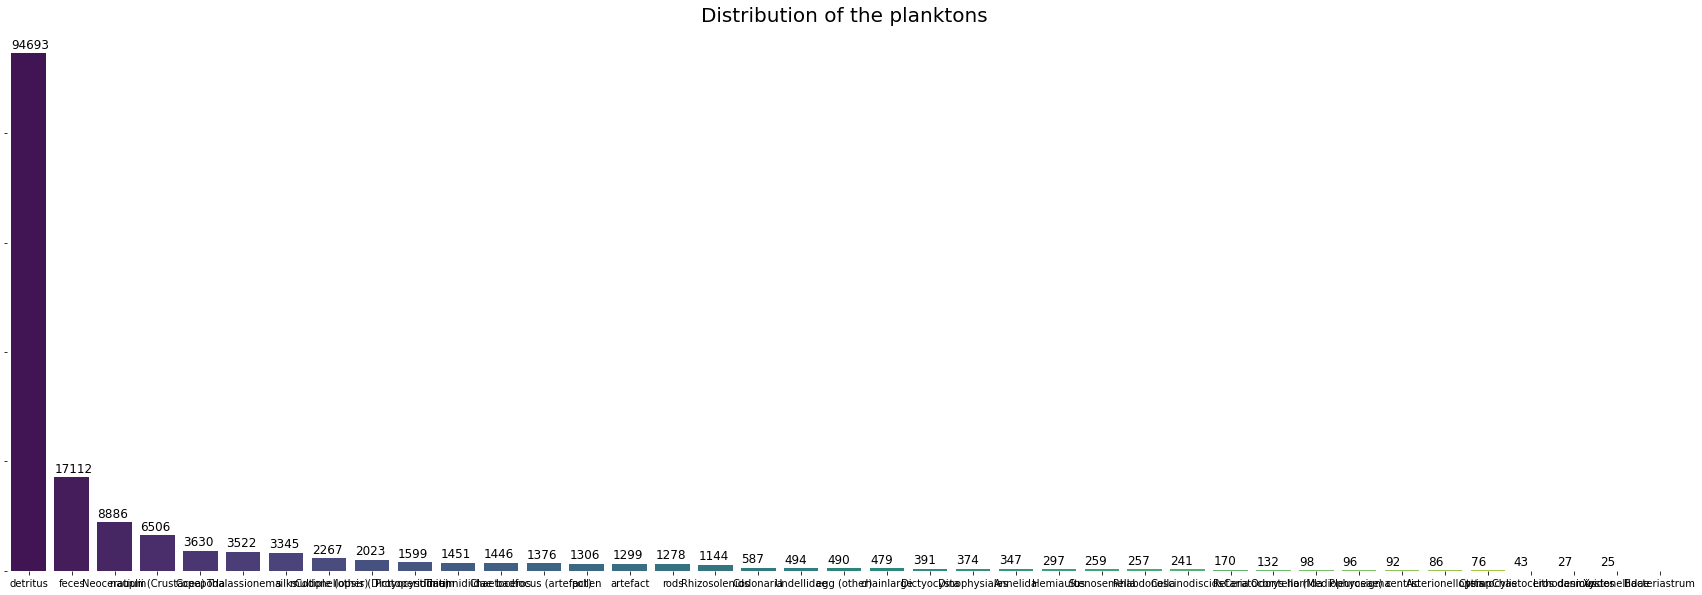

In [0]:
import seaborn as sns

plt.figure(figsize=(30,10))

g = sns.countplot(y_train_pd.level2, order = y_train_pd['level2'].value_counts().index, palette='viridis')
#g.set_xticklabels(y_train_pd.level2.unique(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of the planktons', fontsize=20)
plt.tick_params(axis='x', which='minor', labelsize=20)

for i in range(len(y_train_pd.level2.unique())-1):
    label = y_train_pd['level2'].value_counts()[i]
    plt.text(x = i - 0.4 , y = label+10**3, s = label, size = 12)

plt.show()

Here is the distribution after data augmentation :

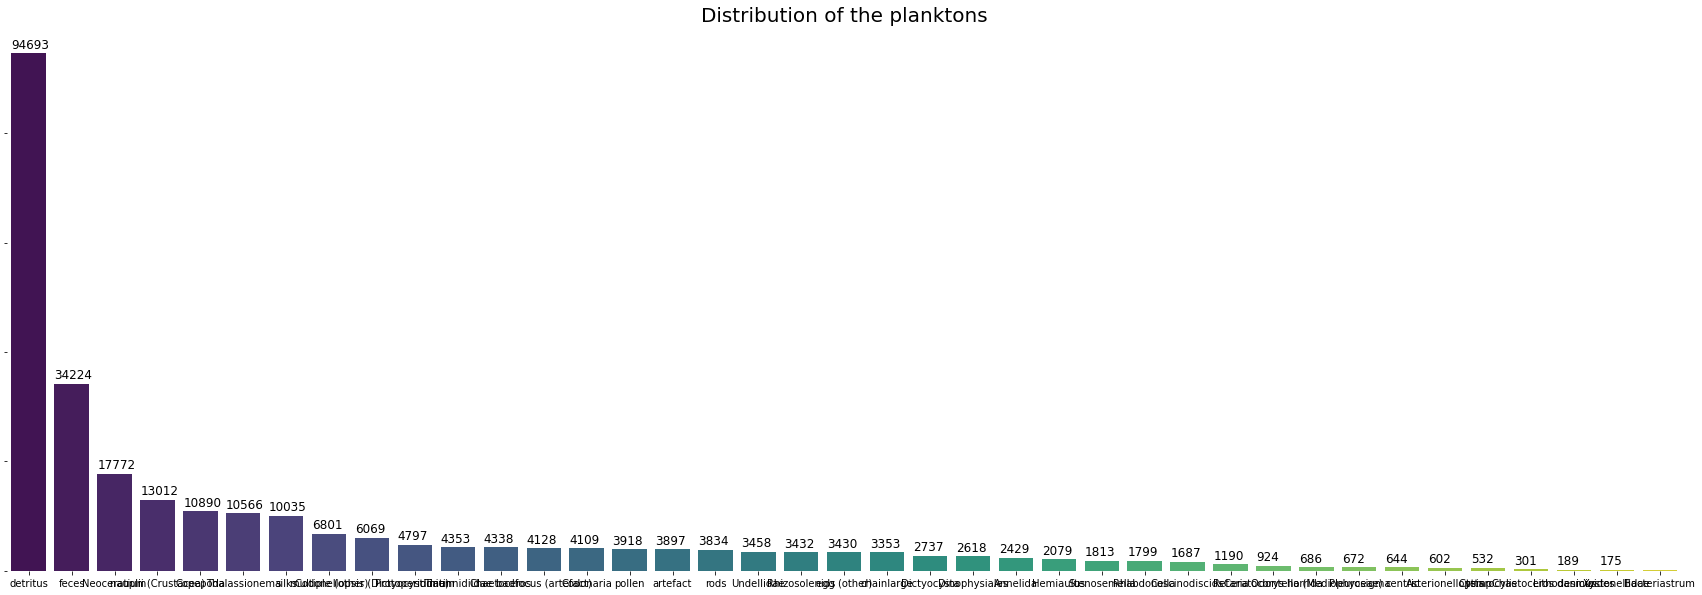

In [0]:
import seaborn as sns

plt.figure(figsize=(30,10))

g = sns.countplot(y_train_final_pd.level2, order = y_train_final_pd['level2'].value_counts().index, palette='viridis')
#g.set_xticklabels(y_train_final_pd.level2.unique(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of the planktons', fontsize=20)
plt.tick_params(axis='x', which='minor', labelsize=20)

for i in range(len(y_train_final_pd.level2.unique())-1):
    label = y_train_final_pd['level2'].value_counts()[i]
    plt.text(x = i - 0.4 , y = label+10**3, s = label, size = 12)

plt.show()

In [0]:
level2_final = pd.DataFrame(y_train_final_pd['level2'].value_counts())
level2_final

,level2
detritus,94693
feces,34224
Neoceratium,17772
nauplii (Crustacea),13012
Copepoda,10890
Thalassionema,10566
silks,10035
multiple (other),6801
Codonellopsis (Dictyocystidae),6069
Protoperidinium,4797


We have kept the shape of the distribution and the order of the classes (ranging from the less populated to the most populated) after data augmentation.

#II. MODEL SELECTION

In this section we are going to test several models on our data. We will perform a **Random Forest** on the extracted features and a couple of pre-trained CNN on the images : **LeNet5**, **AlexNet** and **VGG16**. For each of these. models we are going to assess their performance on training data with the **F1-score** metrics with the average=macro option.

We made the choice to exclude **resizing** of the data preparation as each model take a different shape in input even if it will be always square images. This is why in each model section there will be a resizing step that is proper to the model.

## 2. a. Random Forest

### Baseline Approach

Let's try a classical radom forest without tuning and without treatement on the dataset

In [0]:
forest = RandomForestClassifier(n_estimators=10)
forest.fit(xtrain, ytrain)

y_pred_train = forest.predict(xtrain)
y_pred_valid = forest.predict(xvalid)

print('train accuracy', forest.score(xtrain, ytrain))
print('valid accuracy',forest.score(xvalid, yvalid))

train accuracy 0.9929092767281377
valid accuracy 0.8142278310049381


Let's compute the f1 score

In [0]:
f1_score_train_baseline_random_forest=f1_score(ytrain, y_pred_train, average='macro')
f1_score_valid_baseline_random_forest=f1_score(yvalid, y_pred_valid, average='macro')
print('f1_score_train_baseline_random_forest =',f1_score_train_baseline_random_forest)
print('f1_score_valid_baseline_random_forest =',f1_score_valid_baseline_random_forest)

f1_score_train_baseline_random_forest = 0.9852643855311312
f1_score_valid_baseline_random_forest = 0.41016476906903104


Remarks: 
* The F1 score allows to see more if we well predict each class because it makes an average between all the scores of the prediction for each class. In oiur case, it's particularly interesting as we have unbalanced labels... 
* But as a consequence, it's normal that it's really low. If we look at the confusion matrix below, we can se that we really well predict for detritus but not really well for few represented classes. (remember 58% of our labels are detritus but we do better than only predict detritus 82% of accuracy globally) 

Let's plot the confusion matrix to see the classes which have the lowest accuracies. 

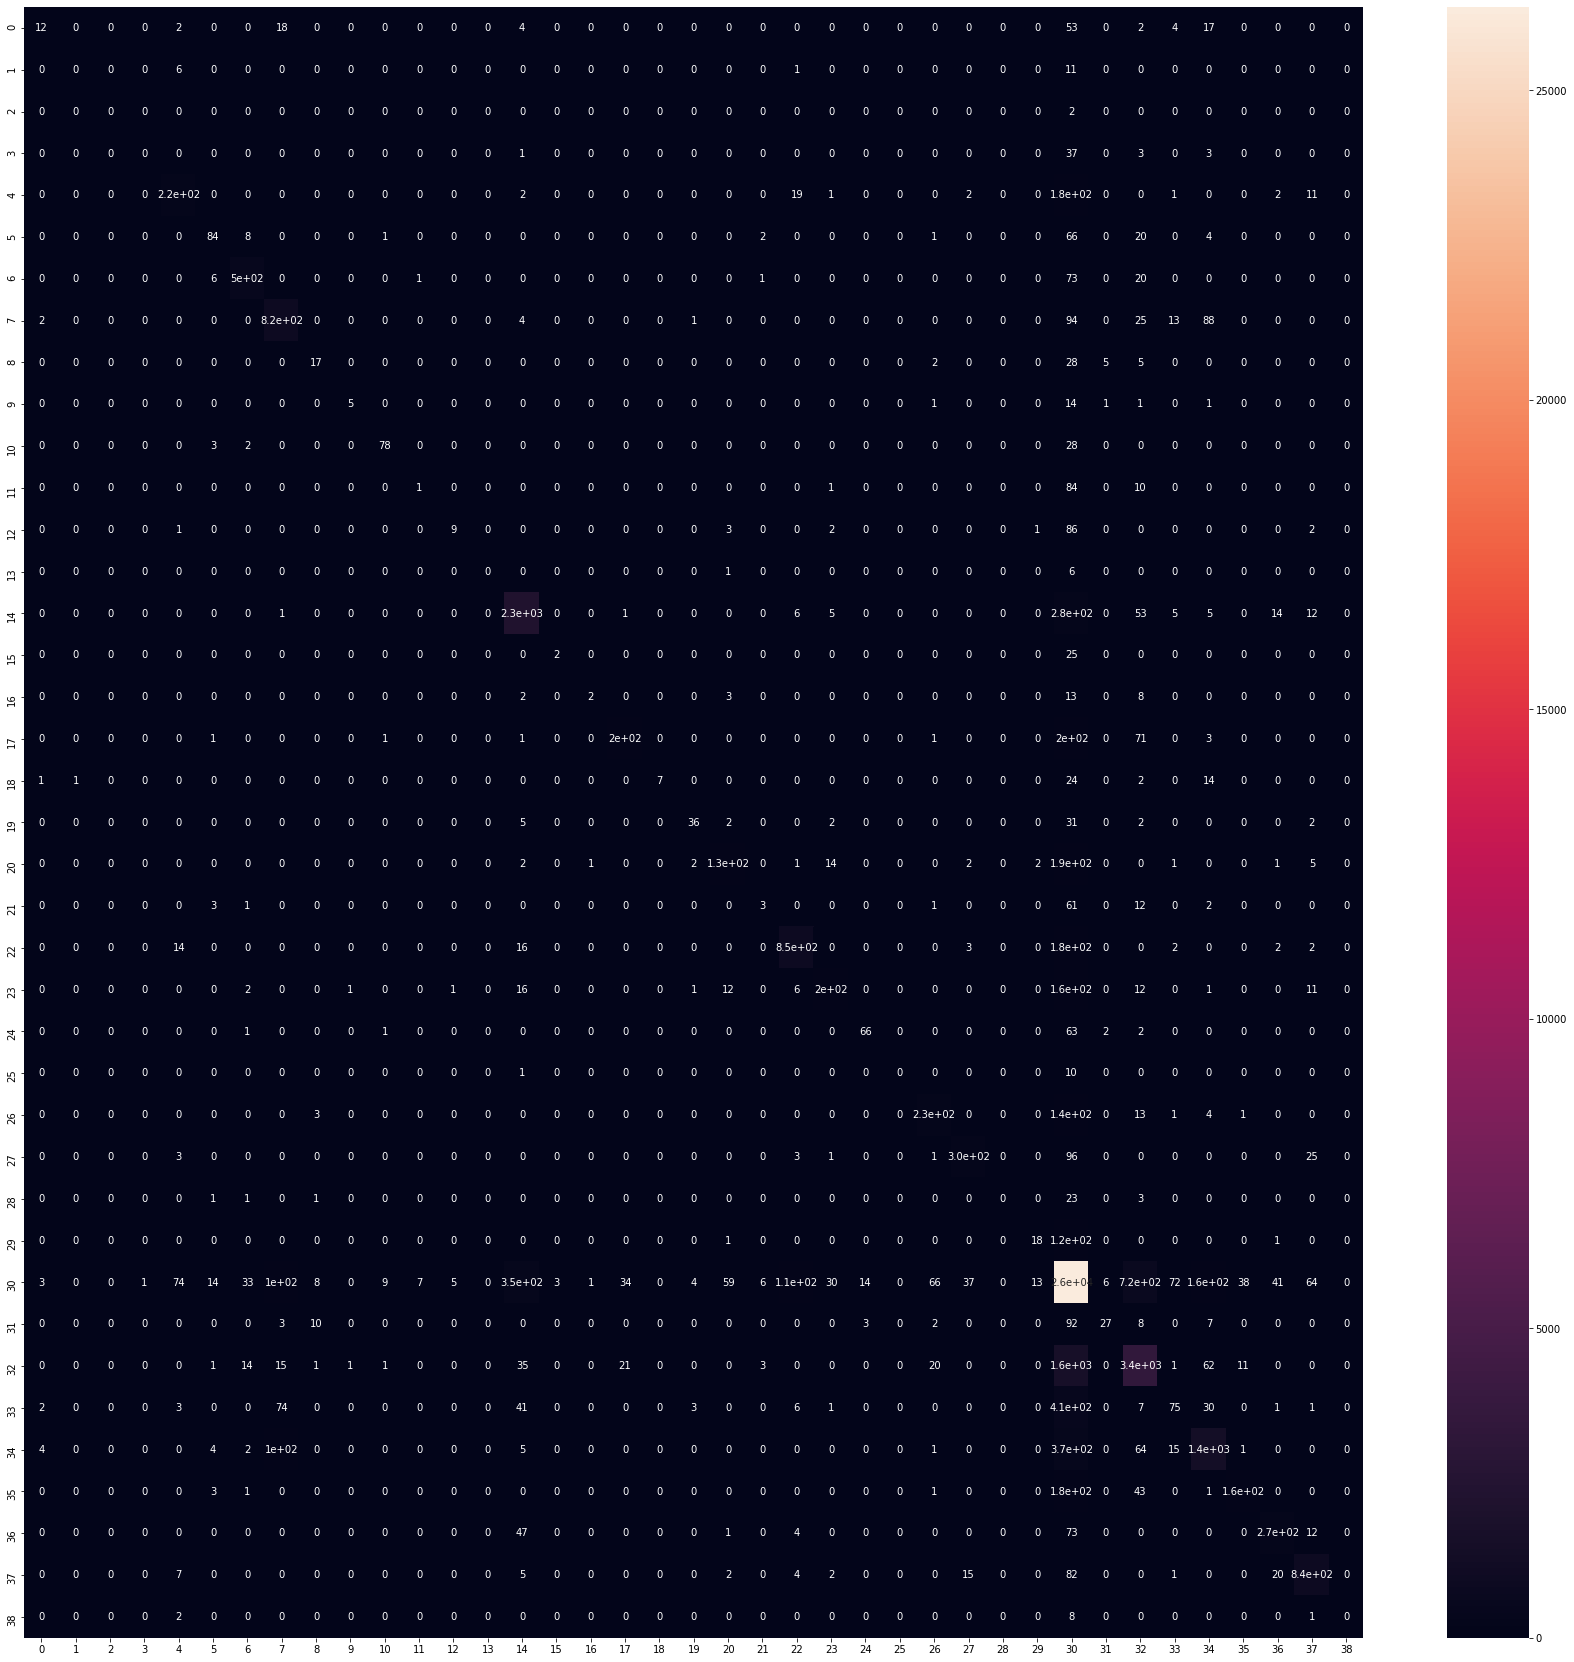

In [0]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(30,30))

sns.heatmap(confusion_matrix(yvalid, y_pred_valid),annot=True)

plt.show()

The results are good, but we should keep lookinf for answers : 
- In order to reduce the number of features : we can try to do a PCA
- In order to deal with the unbalanced data set : https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

### Working on the number of features : PCA 

Remark: as we naively merged the two datasets (native and skimage), it's particlaurly relevant to see if there are not redundant inforamtion. So, we do a PCA!

> Normalizing the data

In [0]:
  #train
scaler = MinMaxScaler() #all the values of the dataset are between 0 and 1.
xtrain_norm = scaler.fit_transform(xtrain)
xtrain_norm = pd.DataFrame(xtrain_norm)

  #test
xtest_norm = scaler.fit_transform(X_test)
xtest_norm = pd.DataFrame(xtest_norm)

  #valid
xvalid_norm = scaler.fit_transform(xvalid)
xvalid_norm = pd.DataFrame(xvalid_norm)

> PCA on normalized data

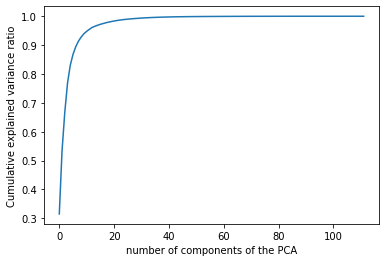

In [0]:
pca = decomposition.PCA(n_components=112)
principal_components = pca.fit_transform(xtrain_norm)
principal_components = pd.DataFrame(principal_components)
cum_var_ratio=pca.explained_variance_ratio_.cumsum()
plt.plot(cum_var_ratio)
plt.xlabel('number of components of the PCA')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

In [0]:
cum_var_ratio[30]

0.9936632869564035

> But what about Random Forest on normalized?

In [0]:
forest_norm = RandomForestClassifier(n_estimators=10)
forest_norm.fit(xtrain_norm, ytrain)
y_pred_train_norm = forest_norm.predict(xtrain_norm)
y_pred_valid_norm = forest_norm.predict(xvalid_norm)
print('train accuracy', forest_norm.score(xtrain_norm, ytrain))
print('valid accuracy',forest_norm.score(xvalid_norm, yvalid))

train accuracy 0.9930630296562265
valid accuracy 0.5915460262524797


In [0]:
f1_score_train_norm_random_forest=f1_score(ytrain, y_pred_train_norm, average='macro')
f1_score_valid_norm_random_forest=f1_score(yvalid, y_pred_valid_norm, average='macro')
print('f1_score_train_baseline_random_forest =',f1_score_train_norm_random_forest)
print('f1_score_valid_baseline_random_forest =',f1_score_valid_norm_random_forest)

f1_score_train_baseline_random_forest = 0.9827219185618088
f1_score_valid_baseline_random_forest = 0.18616208277467342


It looks like we overfit a lot

It seems it works better on standardized data. 

Let us try to find the optimized **n_trees** on standardized data

In [0]:
n_trees = []
train_f1_forest = []
valid_f1_forest = []
train_accuracy_forest = []
valid_accuracy_forest = []

max_f1 = 0

for n in range (1, 25,3):
    n_trees.append(n)
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(xtrain_norm, ytrain)
    y_pred_train = forest.predict(xtrain_norm)
    y_pred_valid = forest.predict(xvalid_norm)
    f1_train=f1_score(ytrain, y_pred_train, average='macro')
    f1_valid=f1_score(yvalid, y_pred_valid, average='macro')
    train_f1_forest.append(f1_train)
    valid_f1_forest.append(f1_valid)
    train_accuracy_forest.append(forest.score(xtrain_norm, ytrain))
    valid_accuracy_forest.append(forest.score(xvalid_norm, yvalid))
    if f1_valid > max_f1:
      n_tree = n
      max_f1 = f1_valid
      accuracy = forest.score(xvalid_norm, yvalid)
      y_pred_forest = y_pred_valid

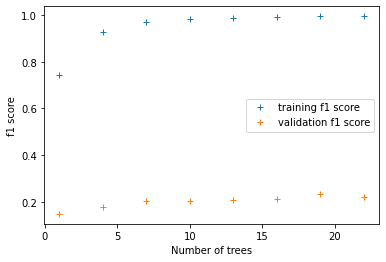

In [0]:
plt.xlabel('Number of trees')
plt.ylabel('f1 score')
plt.plot(n_trees, train_f1_forest, '+', label = "training f1 score")
plt.plot(n_trees, valid_f1_forest, '+', label = "validation f1 score")
plt.legend()
plt.show()

In [0]:
max_f1 = max(valid_f1_forest)
n_tree = n_trees[np.argmax(valid_f1_forest)]
accuracy = valid_accuracy_forest[np.argmax(valid_f1_forest)]
print('Max f1 on the validation set of %.2f' % max_f1, 'with an accuracy of %.4f' % accuracy,  'obtained with ', n_tree, 'trees')

Max f1 on the validation set of 0.23 with an accuracy of 0.6545 obtained with  19 trees


In [0]:
max_f1

0.2325387545732179

In this dataset, normalizing impacts badly our accuracy...

24 PCA components explain 99% of the variance... so we can keep only these 24 PCA components

In [0]:
pca = decomposition.PCA(n_components=50)
pca.fit(xtrain_norm)
xtrain_PCA = pca.transform(xtrain_norm)

In [0]:
xvalid_PCA= pca.transform(xvalid_norm)

Let's try again prediction with this PCA

In [0]:
forest_PCA = RandomForestClassifier(n_estimators=10)
forest_PCA.fit(xtrain_PCA, ytrain)
y_pred_train_PCA = forest_PCA.predict(xtrain_PCA)
y_pred_valid_PCA = forest_PCA.predict(xvalid_PCA)
print('train accuracy', forest_PCA.score(xtrain_PCA, ytrain))
print('valid accuracy',forest_PCA.score(xvalid_PCA, yvalid))

train accuracy 0.9922671321461195
valid accuracy 0.6478073692651838


In [0]:
f1_score_train_PCA_baseline_random_forest=f1_score(ytrain, y_pred_train_PCA, average='macro')
f1_score_valid_PCA_baseline_random_forest=f1_score(yvalid, y_pred_valid_PCA, average='macro')
print('f1_score_train_PCA_baseline_random_forest =',f1_score_train_PCA_baseline_random_forest)
print('f1_score_valid_PCA_baseline_random_forest =',f1_score_valid_PCA_baseline_random_forest)

f1_score_train_PCA_baseline_random_forest = 0.983607421851446
f1_score_valid_PCA_baseline_random_forest = 0.20554547818632224


Let us forget about PCA, as the model overfits too much.

### Working on unbalanced data set

#### 1. Firt idea: Over sampling using SMOTE

In [0]:
lev2_distrib_train=pd.DataFrame(y_train['level2'].value_counts())

In [0]:
lev2_distrib_train

,level2
detritus,96831
feces,18907
Neoceratium,9800
nauplii (Crustacea),6487
badfocus (artefact),5435
silks,3949
Copepoda,3615
Thalassionema,3606
rods,2840
multiple (other),2313


In [0]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('auto')

In [0]:
#X_sm, y_sm=smote.fit_sample(xtrain,ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

ValueError: ignored

SMOTE is not relevant here to increase the number of rows in under represented class: SMOTE uses a KNN algo but some class are too under represented so it's impossible to create samples around them...

#### Under Sampling : keeping only 10% of each labels

We already did it for the NN method.

In [0]:
merged_inner = pd.merge(left=X_train, right=y_train, left_on='objid', right_on='objid')
merged_inner

,objid,area_native,meanimagegrey,mean,stddev,min,perim.,width,height,major,minor,angle,circ.,feret,intden,median,skew,kurt,%area,area_exc,fractal,skelarea,slope,histcum1,histcum2,histcum3,nb1,nb2,nb3,symetrieh,symetriev,symetriehc,symetrievc,convperim,convarea,fcons,thickr,esd,elongation,range,...,moments_hu3,moments_hu4,moments_hu5,moments_hu6,moments_normalized2,moments_normalized3,moments_normalized5,moments_normalized6,moments_normalized7,moments_normalized8,moments_normalized9,moments_normalized10,moments_normalized11,moments_normalized12,moments_normalized13,moments_normalized14,moments_normalized15,perimeter,solidity,weighted_moments_hu0,weighted_moments_hu1,weighted_moments_hu2,weighted_moments_hu3,weighted_moments_hu4,weighted_moments_hu5,weighted_moments_hu6,weighted_moments_normalized2,weighted_moments_normalized3,weighted_moments_normalized5,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15,level2
0,32687796.0,4161.0,168.04,156.22,81.101,71,242.45,70,76,94.8,88.0,90,0.890,79.6,1023582.0,116,0.261,-1.802,100.00,0.0,1.217,6539.0,0.133,249,251,253,0,0,0,1.382,1.380,4,4,6263.0,2391.0,13.542,4.512,106,1.079545,184,...,2.884103e+01,3.176153e-07,-1.467892e-01,-0.000016,8.510752e+07,-7.298238e+05,-7.657607e+06,-3.671461e+05,-1.435252e+06,7.528796e+07,7.540764e+05,4.401027e+06,9.268104e+04,1.990603e+05,-1.046520e+06,-4.303192e+04,-1.549097e+05,240.793939,0.983455,6.980384e+05,5.861192,0.000896,0.000004,-2.603350e-19,-3.372295e-10,9.419056e-20,3.679584e+05,-2.456081e+02,-3.326564e+04,-99.174206,-26.794157,3.300799e+05,212.786371,83.791462,0.104749,41.482183,-20.269114,-0.053136,-0.012950,detritus
1,32657081.0,1492.0,166.73,242.21,37.129,71,350.84,102,119,143.3,124.1,90,0.152,149.5,3383731.0,255,-3.172,8.932,96.58,51.0,1.012,13970.0,1.470,215,251,252,9,4,4,1.446,1.437,11,11,13970.0,13970.0,160.965,1.008,106,1.153226,184,...,6.897129e+07,5.156696e+06,8.738844e+07,-114502.128683,7.915565e+08,8.837613e+07,-6.351011e+08,-9.727583e+07,-8.518019e+08,5.242478e+08,9.625016e+07,7.002726e+08,2.722764e+08,-8.949789e+07,-5.867295e+08,-2.506091e+08,-9.507918e+08,448.233585,0.609045,8.095991e+06,64016.923159,76.380867,72.028010,5.342436e-06,5.732482e-01,-2.586542e-08,4.855137e+06,1.085579e+05,-3.918259e+06,-100825.949369,-34430.432573,3.240854e+06,90480.335656,28545.491480,1650.375255,-79206.809001,-24019.710061,-1445.600651,-270.778050,detritus
2,32591458.0,1705.0,0.00,121.29,63.507,69,908.24,87,90,110.6,107.2,90,0.026,95.2,1129171.0,91,1.583,0.578,86.74,226.0,1.015,9310.0,1.798,87,89,91,7,16,15,1.417,1.427,1,2,9310.0,9310.0,0.249,1.010,0,1.037383,186,...,9.219663e+06,-6.743119e+04,-5.602412e+05,-276722.145765,2.644149e+08,-8.915729e+07,-9.470575e+07,9.194321e+06,-4.065161e+07,2.859823e+08,6.830653e+07,5.196525e+07,1.229953e+07,-1.029222e+08,-6.365633e+07,-2.187675e+07,-1.608452e+07,918.186904,0.303758,2.428033e+06,707.906060,8.893074,0.794173,-5.175175e-10,-2.143789e-04,-2.046132e-09,1.164622e+06,-2.619588e+04,-4.177759e+05,2713.382977,-790.512674,1.263411e+06,19986.902154,1009.707843,15.759195,-30201.954744,-1239.351303,-28.195207,-1.376632,detritus
3,32742368.0,1776.0,170.35,247.55,17.593,139,450.16,61,81,100.4,77.9,90,0.110,83.4,1520214.0,255,-3.118,10.229,60.08,709.0,1.019,6141.0,0.334,223,243,251,6,17,16,1.484,1.484,3,3,6141.0,6141.0,179.970,1.011,108,1.282051,116,...,7.592044e+06,7.682415e+04,2.133460e+06,-60922.464364,4.249862e+08,-9.133849e+07,-7.570032e+07,2.834931e+07,-8.341203e+07,1.753399e+08,1.142702e+07,4.933454e+07,-1.774227e+07,6.381098e+06,-1.133364e+07,7.814982e+06,-1.579592e+07,649.990945,0.332602,8.468200e+06,22207.272921,98.224563,94.049440,8.960106e-06,4.411102e-01,-1.195427e-06,6.267678e+06,-2.729720e+05,-1.190117e+06,80246.647150,-20706.952098,2.200522e+06,-18767.985604,10

In [0]:
level2_cat = merged_inner.level2.unique()
level2_cat

array(['detritus', 'nauplii (Crustacea)', 'feces',
       'Codonellopsis (Dictyocystidae)', 'rods', 'Copepoda', 'pollen',
       'silks', 'Neoceratium', 'Thalassionema', 'badfocus (artefact)',
       'egg (other)', 'Hemiaulus', 'Rhizosolenids', 'Retaria', 'artefact',
       'chainlarge', 'multiple (other)', 'Stenosemella', 'Dictyocysta',
       'Chaetoceros', 'Dinophysiales', 'Tintinnidiidae', 'Rhabdonella',
       'Protoperidinium', 'Codonaria', 'tempChaetoceros danicus',
       'centric', 'Cyttarocylis', 'Annelida', 'Ceratocorys horrida',
       'Undellidae', 'Odontella (Mediophyceae)', 'Lithodesmioides',
       'Coscinodiscids', 'Pleurosigma', 'Bacteriastrum', 'Xystonellidae',
       'Asterionellopsis'], dtype=object)

Let us keep in memory the 'objid' of the images we will drop

In [0]:
objid = np.array(['1']) # I'm obliged to initialise a random array (that I will drop later)

for cat in level2_cat: 
  X_cat = merged_inner[merged_inner['level2']==cat]
  number_img_kept = round(np.shape(X_cat)[0]*0.1) #We keep 10% of each cat
  
  X_cat = X_cat.sample(n = number_img_kept)
  objid_kept = X_cat.objid.values

  objid = np.concatenate((objid, objid_kept))

objid = np.delete(objid, 0) 

In [0]:
np.shape(objid)

(16983,)

In [0]:
train_set_reshaped = merged_inner[merged_inner['objid'].isin(objid)]
train_set_reshaped

,objid,area_native,meanimagegrey,mean,stddev,min,perim.,width,height,major,minor,angle,circ.,feret,intden,median,skew,kurt,%area,area_exc,fractal,skelarea,slope,histcum1,histcum2,histcum3,nb1,nb2,nb3,symetrieh,symetriev,symetriehc,symetrievc,convperim,convarea,fcons,thickr,esd,elongation,range,...,moments_hu3,moments_hu4,moments_hu5,moments_hu6,moments_normalized2,moments_normalized3,moments_normalized5,moments_normalized6,moments_normalized7,moments_normalized8,moments_normalized9,moments_normalized10,moments_normalized11,moments_normalized12,moments_normalized13,moments_normalized14,moments_normalized15,perimeter,solidity,weighted_moments_hu0,weighted_moments_hu1,weighted_moments_hu2,weighted_moments_hu3,weighted_moments_hu4,weighted_moments_hu5,weighted_moments_hu6,weighted_moments_normalized2,weighted_moments_normalized3,weighted_moments_normalized5,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15,level2
20,32652320.0,2345.0,163.85,207.88,52.838,130,229.18,65,59,82.4,75.6,0,0.561,66.2,1016729.0,251,-0.388,-1.707,99.96,1.0,1.020,4891.0,0.364,136,149,217,2,2,1,1.410,1.409,2,2,4891.0,4891.0,47.472,1.014,104,1.078947,125,...,3.733014e+03,-0.231629,-3.230220e+01,0.156679,8.598018e+07,-6.536712e+06,4.458233e+06,5.470343e+06,1.096525e+06,8.915094e+07,8.311638e+06,5.579497e+06,6.810434e+05,-6.233661e+06,2.985551e+05,5.859106e+05,2.011002e+05,235.929978,0.884195,1.017899e+06,2.232350,0.346221,0.002862,7.326378e-14,-1.149375e-07,5.242943e-14,5.091616e+05,-3000.603970,23622.922840,2559.838278,41.955260,5.087375e+05,3816.845015,187.738589,1.871209,-4041.646691,-10.480287,1.071954,0.036039,feces
41,32677186.0,17899.0,152.68,186.97,74.359,66,1366.44,112,293,339.6,135.4,90,0.120,299.1,6753444.0,244,-0.342,-1.756,98.99,180.0,1.007,36120.0,2.622,90,108,233,11,1,4,2.081,2.084,4,4,36120.0,36120.0,347.414,1.003,96,2.518519,189,...,1.195539e+06,2009.071014,2.607521e+05,341.286891,2.575432e+08,-3.404384e+07,2.954381e+07,-1.067771e+07,1.702768e+07,3.428296e+07,9.799902e+05,7.306571e+06,-1.295775e+06,5.623231e+05,1.787820e+06,-5.206670e+05,8.945894e+05,1551.567676,0.748079,1.328515e+06,1079.310177,0.311593,0.174310,4.003667e-11,1.693522e-04,6.880784e-12,1.169791e+06,-12783.689583,119431.655626,-3878.667218,361.421354,1.587245e+05,159.109687,152.885409,-2.555593,14.677569,32.159027,-0.984227,0.087242,Copepoda
43,32742775.0,2420.0,169.31,207.29,60.915,69,334.96,82,46,101.6,60.9,0,0.271,83.0,1007439.0,247,-0.942,-0.645,96.82,77.0,1.023,4860.0,0.165,116,182,234,1,3,4,1.596,1.589,2,2,4860.0,4860.0,72.409,1.011,106,1.672131,186,...,2.735496e+05,95.009120,2.651882e+04,23.011767,4.930314e+07,-5.358698e+05,1.741031e+07,-9.753304e+05,2.498974e+06,1.700743e+08,-2.824775e+06,7.388061e+06,-1.144833e+05,1.716964e+07,2.750368e+06,6.468665e+05,5.263673e+05,488.457936,0.784137,1.171762e+06,361.436862,0.208666,0.191381,3.773947e-11,1.074225e-04,6.196904e-12,2.967904e+05,-567.232181,82375.938441,-154.633958,71.361665,8.749717e+05,-46.454139,233.471966,0.287639,13975.052022,85.450743,4.258499,0.101136,detritus
56,31339147.0,224.0,172.46,253.61,2.908,224,187.08,16,32,45.1,27.1,90,0.080,32.8,243468.0,255,-4.068,27.396,84.82,34.0,1.003,960.0,0.091,248,250,252,0,0,0,1.551,1.534,3,3,960.0,960.0,8.496,1.026,108,1.666667,31,...,3.226313e+05,-10.189863,-2.323105e+04,231.462531,3.037941e+08,1.129469e+07,1.269281e+06,1.303604e+07,-9.649967e+06,6.771891e+07,-7.843761e+05,2.126704e+07,2.130154e+06,1.529831e+06,1.541433e+06,2.534414e+06,-1.095382e+05,148.225397,0.472637,3.562453e+07,499228.097115,2815.721191,913.963041,1.012984e-03,9.458096e+00,1.059977e-03,2.897220e+07,867102.344745,512714.736639,455699.364067,-61685.267616,6.652332e+06,-60985.888391,196289.709355,7497.937644,58245.477580,18142.219912,8350.147470,278.671677,badfocus (a

In [0]:
X_train_reshape = train_set_reshaped.drop(['level2'],axis=1)
X_train_reshape = X_train_reshape.drop(['objid'],axis=1)

In [0]:
y_train_reshape = train_set_reshaped[['level2']]

In [0]:
xtrain_reduced, xvalid_reduced = split(X_train_reshape)
ytrain_reduced, yvalid_reduced = split(y_train_reshape)

16983
[11888  5095]
16983
[11888  5095]


Let us try Random Forest

In [0]:
forest_rus = RandomForestClassifier(n_estimators=10)
forest_rus.fit(xtrain_reduced, ytrain_reduced)
y_pred_train_rus = forest_rus.predict(xtrain_reduced)
y_pred_valid_rus = forest_rus.predict(xvalid_reduced)
print('train accuracy', forest_rus.score(xtrain_reduced, ytrain_reduced))
print('valid accuracy',forest_rus.score(xvalid_reduced, yvalid_reduced))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


train accuracy 0.993606998654105
valid accuracy 0.7784102060843965


In [0]:
f1_score_train_rus_baseline_random_forest=f1_score(ytrain_reduced, y_pred_train_rus, average='macro')
f1_score_valid_rus_baseline_random_forest=f1_score(yvalid_reduced, y_pred_valid_rus, average='macro')
print('f1_score_train_rus_baseline_random_forest =',f1_score_train_rus_baseline_random_forest)
print('f1_score_valid_rus_baseline_random_forest =',f1_score_valid_rus_baseline_random_forest)

f1_score_train_rus_baseline_random_forest = 0.9904466560663523
f1_score_valid_rus_baseline_random_forest = 0.318499412019292


In [0]:
n_trees_2 = np.arange(1,220,20)
train_f1_forest_2 = []
valid_f1_forest_2 = []
train_accuracy_forest_2 = []
valid_accuracy_forest_2 = []

max_f1 = 0

for n in range (1, 220,20):
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(xtrain_reduced, ytrain_reduced)

    y_pred_train = forest.predict(xtrain_reduced)
    y_pred_valid = forest.predict(xvalid_reduced)

    f1_train=f1_score(ytrain_reduced, y_pred_train, average='macro')
    f1_valid=f1_score(yvalid_reduced, y_pred_valid, average='macro')

    train_f1_forest_2.append(f1_train)
    valid_f1_forest_2.append(f1_valid)

    train_accuracy_forest_2.append(forest.score(xtrain_reduced, ytrain_reduced))
    valid_accuracy_forest_2.append(forest.score(xvalid_reduced, yvalid_reduced))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

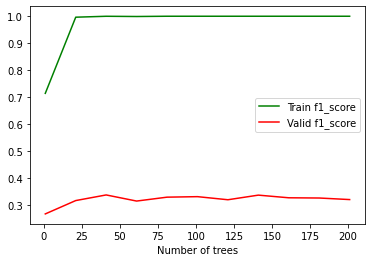

In [0]:
plt.figure()

plt.xlabel('Number of trees')
plt.plot(n_trees_2,train_f1_forest_2,color='green',label='Train f1_score')
plt.plot(n_trees_2,valid_f1_forest_2,color='red',label='Valid f1_score')
plt.legend()
plt.show()

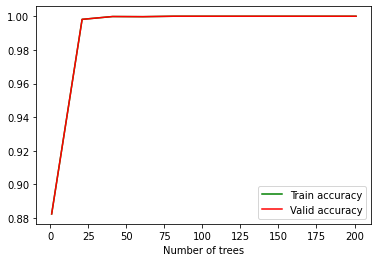

In [0]:
plt.figure()

plt.xlabel('Number of trees')
plt.plot(n_trees_2,train_accuracy_forest_2,color='green',label='Train accuracy')
plt.plot(n_trees_2,train_accuracy_forest_2,color='red',label='Valid accuracy')
plt.legend()
plt.show()

#### Under Sampling : arbitary choices of what we keep

In [0]:
sampl_strat = {'detritus':4000, 'feces':2000, 'Neoceratium':1500, 'nauplii (Crustacea)':1300,
       'badfocus (artefact)':1200, 'silks':1100, 'Copepoda':1000, 'Thalassionema':900,
       'rods':850, 'multiple (other)':800, 'Codonellopsis (Dictyocystidae)':750,
       'Protoperidinium':700, 'Tintinnidiidae':650, 'Rhizosolenids':600,
       'Chaetoceros':550, 'artefact':500, 'pollen':350, 'Codonaria':350, 'chainlarge':347,
       'Undellidae':368, 'egg (other)':350, 'Hemiaulus':314, 'Dictyocysta':280,
       'Dinophysiales':266, 'Annelida':244, 'Rhabdonella':175, 'Stenosemella':177,
       'Coscinodiscids':180, 'Retaria':130, 'Pleurosigma':96, 'Ceratocorys horrida':91,
       'centric':75, 'Odontella (Mediophyceae)':75, 'Asterionellopsis':46,
       'Cyttarocylis':54, 'Lithodesmioides':35, 'tempChaetoceros danicus':33,
       'Xystonellidae':13, 'Bacteriastrum':3 }

In [0]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=sampl_strat) # in sampl_strat, we put the number of rows we want to keep of each class
X_rus, y_rus=rus.fit_sample(xtrain,ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print(X_rus.shape)
y_rus_df=pd.DataFrame(y_rus, columns=['level2'])
y_rus_df

In [0]:
lev2_distrib_train_rus=pd.DataFrame(y_rus_df['level2'].value_counts()/len(y_rus_df)*100)

In [0]:
lev2_distrib_train_rus

,level2
detritus,25.542784
feces,12.771392
Neoceratium,6.385696
nauplii (Crustacea),5.108557
badfocus (artefact),4.469987
silks,3.831418
Thalassionema,3.512133
Copepoda,3.192848
rods,2.554278
Undellidae,2.349936


In [0]:
forest_rus = RandomForestClassifier(n_estimators=10)
forest_rus.fit(X_rus, y_rus)
y_pred_train_rus = forest_rus.predict(X_rus)
y_pred_valid_rus = forest_rus.predict(xvalid)
print('train accuracy', forest_rus.score(X_rus, y_rus))
print('valid accuracy',forest_rus.score(xvalid, yvalid))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


train accuracy 0.9938058748403577
valid accuracy 0.7441508989557981


In [0]:
f1_score_train_rus_baseline_random_forest=f1_score(y_rus, y_pred_train_rus, average='macro')
f1_score_valid_rus_baseline_random_forest=f1_score(yvalid, y_pred_valid_rus, average='macro')
print('f1_score_train_rus_baseline_random_forest =',f1_score_train_rus_baseline_random_forest)
print('f1_score_valid_rus_baseline_random_forest =',f1_score_valid_rus_baseline_random_forest)

f1_score_train_rus_baseline_random_forest = 0.9917658196772674
f1_score_valid_rus_baseline_random_forest = 0.4162328771893215


Remark: For the moment, I dont manage to obtain a better acuracy/F1 score. Nevertheless, we can see that for this smaller dataset with less rows of over represented labels, we can obtain the same f1 score as the first model with a smaller accuracy!! It means that we predict better for the class under represented (the true predictions are more 'balanced' part from each class is well predicted

###  Tuning the parameters for the 'best' model for the moment

In [0]:
n_trees = []
train_f1_forest = []
valid_f1_forest = []
train_accuracy_forest = []
valid_accuracy_forest = []

max_f1 = 0

for n in range (1, 40,2):
    n_trees.append(n)
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(xtrain, ytrain)
    y_pred_train = forest.predict(xtrain)
    y_pred_valid = forest.predict(xvalid)
    f1_train=f1_score(ytrain, y_pred_train, average='macro')
    f1_valid=f1_score(yvalid, y_pred_valid, average='macro')
    train_f1_forest.append(f1_train)
    valid_f1_forest.append(f1_valid)
    train_accuracy_forest.append(forest.score(xtrain, ytrain))
    valid_accuracy_forest.append(forest.score(xvalid, yvalid))
    if f1_valid > max_f1:
      n_tree = n
      max_f1 = f1_valid
      accuracy = forest.score(xvalid, yvalid)
      y_pred_forest = y_pred_valid



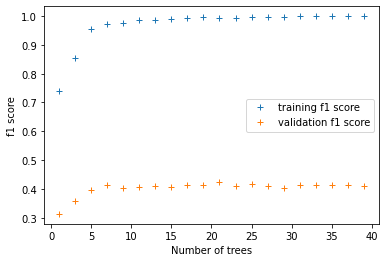

In [0]:
plt.xlabel('Number of trees')
plt.ylabel('f1 score')
plt.plot(n_trees, train_f1_forest, '+', label = "training f1 score")
plt.plot(n_trees, valid_f1_forest, '+', label = "validation f1 score")
plt.legend()
plt.show()

In [0]:
max_f1 = max(valid_f1_forest)
n_tree = n_trees[np.argmax(valid_f1_forest)]
accuracy = valid_accuracy_forest[np.argmax(valid_f1_forest)]
print('Max f1 on the validation set of %.2f' % max_f1, 'with an accuracy of %.4f' % accuracy,  'obtained with ', n_tree, 'trees')

Max f1 on the validation set of 0.43 with an accuracy of 0.8245 obtained with  21 trees


##1. b. LeNet5 on the images

###3rd step: One-hot encoding of the labels

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [0]:
enc.categories_

[array(['Annelida', 'Asterionellopsis', 'Bacteriastrum',
        'Ceratocorys horrida', 'Chaetoceros', 'Codonaria',
        'Codonellopsis (Dictyocystidae)', 'Copepoda', 'Coscinodiscids',
        'Cyttarocylis', 'Dictyocysta', 'Dinophysiales', 'Hemiaulus',
        'Lithodesmioides', 'Neoceratium', 'Odontella (Mediophyceae)',
        'Pleurosigma', 'Protoperidinium', 'Retaria', 'Rhabdonella',
        'Rhizosolenids', 'Stenosemella', 'Thalassionema', 'Tintinnidiidae',
        'Undellidae', 'Xystonellidae', 'artefact', 'badfocus (artefact)',
        'centric', 'chainlarge', 'detritus', 'egg (other)', 'feces',
        'multiple (other)', 'nauplii (Crustacea)', 'pollen', 'rods',
        'silks', 'tempChaetoceros danicus'], dtype=object)]

In [0]:
ytrain= enc.transform(y_train_split.reshape(-1,1)).toarray()

In [0]:
yvalid=enc.transform(y_valid_split.reshape(-1,1)).toarray()

In [0]:
ytest=enc.transform(y_test.reshape(-1,1)).toarray()

In [0]:
print('shape of ytrain=', ytrain.shape)
print('shape of yvalid=', yvalid.shape)
print('shape of ytest=', ytest.shape)

shape of ytrain= (110567, 39)
shape of yvalid= (47386, 39)
shape of ytest= (67695, 39)


###Applynig Lenet5

https://github.com/TaavishThaman/LeNet-5-with-Keras/blob/master/lenet_5.py

In [0]:
X_test_for_lenet5_arr=np.array(X_test_for_lenet5)

In [0]:
train = dataset_train.reshape(dataset_train.shape[0], 32, 32, 1)
valid=dataset_valid.reshape(dataset_valid.shape[0], 32, 32, 1)
test = X_test_for_lenet5_arr.reshape(X_test_for_lenet5_arr.shape[0], 32, 32, 1)

In [0]:
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'softmax'))

adam = Adam(lr=0.001)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [0]:
model.fit(train ,ytrain, batch_size=128 , epochs = 42)


Epoch 1/42
110567/110567 [==============================] - 51s 460us/step - loss: 1.4592 - accuracy: 0.6185
Epoch 2/42
110567/110567 [==============================] - 51s 460us/step - loss: 1.0508 - accuracy: 0.6764
Epoch 3/42
110567/110567 [==============================] - 51s 464us/step - loss: 0.9483 - accuracy: 0.6988
Epoch 4/42
110567/110567 [==============================] - 51s 466us/step - loss: 0.8925 - accuracy: 0.7117
Epoch 5/42
110567/110567 [==============================] - 52s 466us/step - loss: 0.8532 - accuracy: 0.7216
Epoch 6/42
110567/110567 [==============================] - 52s 468us/step - loss: 0.8211 - accuracy: 0.7303
Epoch 7/42
110567/110567 [==============================] - 51s 463us/step - loss: 0.7933 - accuracy: 0.7365
Epoch 8/42
110567/110567 [==============================] - 51s 464us/step - loss: 0.7709 - accuracy: 0.7414
Epoch 9/42
110567/110567 [==============================] - 52s 466us/step - loss: 0.7527 - accuracy: 0.7467
Epoch 10/42
110567/

In [0]:
y_pred_valid = model.predict(valid)

In [0]:
y_pred_valid_df=pd.DataFrame(y_pred_valid)

In [0]:
y_pred_labels_one_hot_encoded=y_pred_valid_df.eq(y_pred_valid_df.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y_pred_labels_one_hot_encoded_ar=y_pred_labels_one_hot_encoded.values

In [0]:
labels_pred_valid=enc.inverse_transform(y_pred_labels_one_hot_encoded_ar)

In [0]:
print(labels_pred_valid)

[['detritus']
 ['feces']
 ['detritus']
 ...
 ['detritus']
 ['detritus']
 ['detritus']]


In [0]:
y_pred_train = model.predict(train)
y_pred_train_df=pd.DataFrame(y_pred_train)
y_pred_labels_one_hot_encoded_train=y_pred_train_df.eq(y_pred_train_df.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_ar=y_pred_labels_one_hot_encoded_train.values
labels_pred_train=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_ar)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f_1_score_valid_lenet5=f1_score(y_valid_split,labels_pred_valid, average='macro')
accuracy_score_valid_lenet5=accuracy_score(y_valid_split,labels_pred_valid)

f_1_score_train_lenet5=f1_score(y_train_split,labels_pred_train, average='macro')
accuracy_score_train_lenet5=accuracy_score(y_train_split,labels_pred_train)


In [0]:
print('train f1 score= ', f_1_score_train_lenet5*100, ' %')
print('train acc= ', accuracy_score_train_lenet5*100, ' %')


print('valid f1 score= ', f_1_score_valid_lenet5*100, ' %')
print('valid acc= ', accuracy_score_valid_lenet5*100, ' %')



train f1 score=  62.003989150896835  %
train acc=  81.79655774326878  %
valid f1 score=  28.106178374677842  %
valid acc=  70.0059089182459  %


### Try to change the parameters : learning rate, number of epochs

We try with a higher leaning rate (0.01 instead of 0.001) and I increase the number of epochs to 80

In [0]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'softmax'))

adam = Adam(lr=0.01)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.fit(train ,ytrain, batch_size=128 , epochs = 80)


Epoch 1/80
110567/110567 [==============================] - 56s 503us/step - loss: 1.8685 - accuracy: 0.5975
Epoch 2/80
110567/110567 [==============================] - 55s 500us/step - loss: 1.7456 - accuracy: 0.5994
Epoch 3/80
110567/110567 [==============================] - 56s 504us/step - loss: 1.7443 - accuracy: 0.5994
Epoch 4/80
110567/110567 [==============================] - 56s 504us/step - loss: 1.7431 - accuracy: 0.5994
Epoch 5/80
110567/110567 [==============================] - 56s 508us/step - loss: 1.7429 - accuracy: 0.5994
Epoch 6/80
110567/110567 [==============================] - 56s 509us/step - loss: 1.7427 - accuracy: 0.5994
Epoch 7/80
110567/110567 [==============================] - 56s 507us/step - loss: 1.7424 - accuracy: 0.5994
Epoch 8/80
110567/110567 [==============================] - 56s 509us/step - loss: 1.7417 - accuracy: 0.5994
Epoch 9/80
110567/110567 [==============================] - 56s 508us/step - loss: 1.7416 - accuracy: 0.5994
Epoch 10/80
110567/

KeyboardInterrupt: ignored

The lost is constant ==> This learning rate is not adapted!

In [0]:
y_pred_valid_2 = model.predict(valid)

In [0]:
y_pred_valid_df_2=pd.DataFrame(y_pred_valid_2)

In [0]:
y_pred_labels_one_hot_encoded_2=y_pred_valid_df_2.eq(y_pred_valid_df_2.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded_ar_2=y_pred_labels_one_hot_encoded_2.values

In [0]:
labels_pred_valid_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_ar_2)

In [0]:
y_pred_train_2 = model.predict(train)
y_pred_train_df_2=pd.DataFrame(y_pred_train_2)
y_pred_labels_one_hot_encoded_train_2=y_pred_train_df_2.eq(y_pred_train_df_2.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_ar_2=y_pred_labels_one_hot_encoded_train_2.values
labels_pred_train_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_ar_2)

In [0]:
f_1_score_valid_lenet5=f1_score(y_valid_split,labels_pred_valid_2, average='macro')
accuracy_score_valid_lenet5=accuracy_score(y_valid_split,labels_pred_valid_2)

f_1_score_train_lenet5=f1_score(y_train_split,labels_pred_train_2, average='macro')
accuracy_score_train_lenet5=accuracy_score(y_train_split,labels_pred_train_2)

In [0]:
print('train f1 score with lr=0.01 with 80 epochs= ', f_1_score_train_lenet5*100, ' %')
print('train acc with lr=0.01 with 80 epochs= ', accuracy_score_train_lenet5*100, ' %')


print('valid f1 score with lr=0.01 with 80 epochs= ', f_1_score_valid_lenet5*100, ' %')
print('valid acc with lr=0.01 with 80 epochs= ', accuracy_score_valid_lenet5*100, ' %')

### Change the way we resized the images to see the impact

In [0]:
np.shape(X_train)

(157953, 2)

In [0]:
stri='imgs/'+str(X_train[0][0])+'.jpg'

In [0]:
img=Image.open(img_files[stri])

In [0]:
X_train_for_lenet5=[]
for i in range(157953):
  objid='imgs/'+str(X_train[i][0])+'.jpg'
  img=Image.open(img_files[objid])
  img_resized=img.resize((32,32), resample=Image.BICUBIC) #Here we need to analize and see what can be the best type of resampling to keep the aspect of the image
  X_train_for_lenet5.append( np.array(img_resized))

In [0]:
X_train_for_lenet5_arr=np.array(X_train_for_lenet5)
X_train_for_lenet5_arr.shape


(157953, 32, 32)

In [0]:
np.shape(X_test)

(67695, 2)

In [0]:
X_test_for_lenet5=[]
for i in range(67695):
  objid='imgs/'+str(X_test[i][0])+'.jpg'
  img=Image.open(img_files[objid])
  img_resized=img.resize((32,32), resample=Image.BICUBIC) #Here we need to analize and see what can be the best type of resampling to keep the aspect of the image
  X_test_for_lenet5.append( np.array(img_resized))

In [0]:
def split(ar, prop=[0.7, 0.3]):
  print(len(ar))
  train_test_nb = np.round(np.array(prop)*len(ar)).astype(np.int)
  print(train_test_nb)
  ar_train = ar[:train_test_nb[0]]
  ar_valid = ar[train_test_nb[0]:]
  return ar_train, ar_valid

dataset_train, dataset_valid = split(X_train_for_lenet5_arr)
y_train_split, y_valid_split=split(y_train)


157953
[110567  47386]
157953
[110567  47386]


In [0]:
dataset_train.shape

(110567, 32, 32)

In [0]:
dataset_valid.shape

(47386, 32, 32)

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [0]:
enc.categories_

[array(['Annelida', 'Asterionellopsis', 'Bacteriastrum',
        'Ceratocorys horrida', 'Chaetoceros', 'Codonaria',
        'Codonellopsis (Dictyocystidae)', 'Copepoda', 'Coscinodiscids',
        'Cyttarocylis', 'Dictyocysta', 'Dinophysiales', 'Hemiaulus',
        'Lithodesmioides', 'Neoceratium', 'Odontella (Mediophyceae)',
        'Pleurosigma', 'Protoperidinium', 'Retaria', 'Rhabdonella',
        'Rhizosolenids', 'Stenosemella', 'Thalassionema', 'Tintinnidiidae',
        'Undellidae', 'Xystonellidae', 'artefact', 'badfocus (artefact)',
        'centric', 'chainlarge', 'detritus', 'egg (other)', 'feces',
        'multiple (other)', 'nauplii (Crustacea)', 'pollen', 'rods',
        'silks', 'tempChaetoceros danicus'], dtype=object)]

In [0]:
ytrain= enc.transform(y_train_split.reshape(-1,1)).toarray()

In [0]:
yvalid=enc.transform(y_valid_split.reshape(-1,1)).toarray()

In [0]:
ytest=enc.transform(y_test.reshape(-1,1)).toarray()

In [0]:
print('shape of ytrain=', ytrain.shape)
print('shape of yvalid=', yvalid.shape)
print('shape of ytest=', ytest.shape)

shape of ytrain= (110567, 39)
shape of yvalid= (47386, 39)
shape of ytest= (67695, 39)


In [0]:
X_test_for_lenet5_arr=np.array(X_test_for_lenet5)

In [0]:
train = dataset_train.reshape(dataset_train.shape[0], 32, 32, 1)
valid=dataset_valid.reshape(dataset_valid.shape[0], 32, 32, 1)
test = X_test_for_lenet5_arr.reshape(X_test_for_lenet5_arr.shape[0], 32, 32, 1)

In [0]:
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'softmax'))

adam = Adam(lr=0.001)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.fit(train ,ytrain, batch_size=128 , epochs = 42)


Epoch 1/42
110567/110567 [==============================] - 57s 515us/step - loss: 1.8518 - accuracy: 0.5990
Epoch 2/42
110567/110567 [==============================] - 57s 516us/step - loss: 1.1473 - accuracy: 0.6516
Epoch 3/42
110567/110567 [==============================] - 57s 515us/step - loss: 1.0456 - accuracy: 0.6747
Epoch 4/42
110567/110567 [==============================] - 57s 520us/step - loss: 0.9788 - accuracy: 0.6913
Epoch 5/42
110567/110567 [==============================] - 58s 521us/step - loss: 0.9306 - accuracy: 0.7030
Epoch 6/42
110567/110567 [==============================] - 58s 522us/step - loss: 0.8968 - accuracy: 0.7113
Epoch 7/42
110567/110567 [==============================] - 58s 523us/step - loss: 0.8698 - accuracy: 0.7175
Epoch 8/42
110567/110567 [==============================] - 57s 520us/step - loss: 0.8426 - accuracy: 0.7246
Epoch 9/42
110567/110567 [==============================] - 58s 523us/step - loss: 0.8197 - accuracy: 0.7318
Epoch 10/42
110567/

In [0]:
y_pred_valid = model.predict(valid)

In [0]:
y_pred_valid_df=pd.DataFrame(y_pred_valid)

In [0]:
y_pred_labels_one_hot_encoded=y_pred_valid_df.eq(y_pred_valid_df.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
y_pred_labels_one_hot_encoded_ar=y_pred_labels_one_hot_encoded.values

In [0]:
labels_pred_valid=enc.inverse_transform(y_pred_labels_one_hot_encoded_ar)

In [0]:
print(labels_pred_valid)

[['detritus']
 ['feces']
 ['detritus']
 ...
 ['detritus']
 ['detritus']
 ['detritus']]


In [0]:
y_pred_train = model.predict(train)
y_pred_train_df=pd.DataFrame(y_pred_train)
y_pred_labels_one_hot_encoded_train=y_pred_train_df.eq(y_pred_train_df.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_ar=y_pred_labels_one_hot_encoded_train.values
labels_pred_train=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_ar)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f_1_score_valid_lenet5_cubic_interpo=f1_score(y_valid_split,labels_pred_valid, average='macro')
accuracy_score_valid_lenet5_cubic_interpo=accuracy_score(y_valid_split,labels_pred_valid)

f_1_score_train_lenet5_cubic_interpo=f1_score(y_train_split,labels_pred_train, average='macro')
accuracy_score_train_lenet5_cubic_interpo=accuracy_score(y_train_split,labels_pred_train)


In [0]:
print('train f1 score cubic interpo= ', f_1_score_train_lenet5_cubic_interpo*100, ' %')
print('train acc cubic_interpo= ', accuracy_score_train_lenet5_cubic_interpo*100, ' %')


print('valid f1 score= ', f_1_score_valid_lenet5_cubic_interpo*100, ' %')
print('valid acc= ', accuracy_score_valid_lenet5_cubic_interpo*100, ' %')



train f1 score cubic interpo=  54.91743991619268  %
train acc cubic_interpo=  81.13903786844176  %
valid f1 score=  28.929445282297817  %
valid acc=  70.55670451188114  %


It doesn't change a lot the results!

### Change of data set: impact of the data augmentation

In [0]:

import cv2


### importing the files ##

X_train = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/X_train.npy', allow_pickle = True)
y_train = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/y_train.npy', allow_pickle = True)


### creating the list that will contain the augmented images ###
X_train_augmented = []
y_train_augmented = []




### defining the classes ###

#less than 1000 samples
classes_underrep = ['Codonaria', 'Undellidae', 'egg (other)', 'chainlarge', 'Dictyocysta', 
                    'Dinophysiales', 'Annelida', 'Hemiaulus', 'Stenosemella', 'Rhabdonella',
                    'Coscinodiscids', 'Retaria', 'Ceratocorys horrida', 'Odontella (Mediophyceae)', 
                    'Pleurosigma', 'centric', 'Asterionellopsis', 'Cyttarocylis', 'tempChaetoceros danicus', 
                    'Lithodesmioides', 'Xystonellidae', 'Bacteriastrum']

#1000 - 3600 samples
classes_medrep = ['Tintinnidiidae', 'rods', 'Chaetoceros',
       'artefact', 'Copepoda','Codonellopsis (Dictyocystidae)', 
       'Thalassionema','pollen', 'silks', 'multiple (other)', 
       'badfocus (artefact)', 'Rhizosolenids',
       'Protoperidinium']

#more than 6000 samples except detritus
classes_highrep = ['Neoceratium', 'feces', 'nauplii (Crustacea)']





### running the data augmentation ###

for i in range(len(X_train)):

  img = X_train[i][1] 

  if y_train[i] in classes_underrep : 
    img_vertical = cv2.flip(img, 1)
    img_horizontal = cv2.flip(img, 0)
    img_double_flip = cv2.flip(img, -1)
    img_luminosity = cv2.add(img, 100)
    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE )
    img_rotated_270 = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)

    X_train_augmented.append([X_train[i][0], img_vertical])
    X_train_augmented.append([X_train[i][0], img_horizontal])
    X_train_augmented.append([X_train[i][0], img_double_flip])
    X_train_augmented.append([X_train[i][0], img_luminosity])
    X_train_augmented.append([X_train[i][0], img_rotated_90])
    X_train_augmented.append([X_train[i][0], img_rotated_270])

    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])

  if y_train[i] in classes_highrep :
      img_vertical2 = cv2.flip(img, 1)

      X_train_augmented.append([X_train[i][0], img_vertical2])

      y_train_augmented.append(y_train[i])

  if y_train[i] in classes_medrep :
      img_vertical3 = cv2.flip(img, 1)
      img_horizontal3 = cv2.flip(img, 0)

      X_train_augmented.append([X_train[i][0], img_vertical3])
      X_train_augmented.append([X_train[i][0], img_horizontal3])

      y_train_augmented.append(y_train[i])
      y_train_augmented.append(y_train[i])



### creating the final datasets by concatenation ###

X_train_final = np.concatenate((X_train, X_train_augmented), axis = 0)
y_train_final = np.concatenate((y_train, y_train_augmented), axis = 0)


### saving into binary files ###

#np.save('/content/drive/My Drive/Plankton Recognition Challenge/Data/Datasets augmented/X_train_augmented.npy', X_train_final)
#np.save('/content/drive/My Drive/Plankton Recognition Challenge/Data/Datasets augmented/y_train_augmented.npy', y_train_final)


In [0]:
np.shape(X_train_final)

(272249, 2)

In [0]:
X_train_augmented_for_lenet5=[]
for i in range(272249):
  img_resized=cv2.resize(X_train_final[i][1],(32,32)) #Here we need to analize and see what can be the best type of resampling to keep the aspect of the image
  X_train_augmented_for_lenet5.append(img_resized)

In [0]:
X_train_augmented_for_lenet5_arr=np.array(X_train_augmented_for_lenet5)
X_train_augmented_for_lenet5_arr.shape


(272249, 32, 32)

In [0]:
def split(ar, prop=[0.7, 0.3]):
  print(len(ar))
  train_test_nb = np.round(np.array(prop)*len(ar)).astype(np.int)
  print(train_test_nb)
  ar_train = ar[:train_test_nb[0]]
  ar_valid = ar[train_test_nb[0]:]
  return ar_train, ar_valid

dataset_train_augmented, dataset_valid_augmented = split(X_train_augmented_for_lenet5_arr)
y_train_split_augmented, y_valid_split_augmented=split(y_train_final)


272249
[190574  81675]
272249
[190574  81675]


In [0]:
dataset_train_augmented.shape

(190574, 32, 32)

In [0]:
dataset_valid_augmented.shape

(81675, 32, 32)

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [0]:
enc.categories_

[array(['Annelida', 'Asterionellopsis', 'Bacteriastrum',
        'Ceratocorys horrida', 'Chaetoceros', 'Codonaria',
        'Codonellopsis (Dictyocystidae)', 'Copepoda', 'Coscinodiscids',
        'Cyttarocylis', 'Dictyocysta', 'Dinophysiales', 'Hemiaulus',
        'Lithodesmioides', 'Neoceratium', 'Odontella (Mediophyceae)',
        'Pleurosigma', 'Protoperidinium', 'Retaria', 'Rhabdonella',
        'Rhizosolenids', 'Stenosemella', 'Thalassionema', 'Tintinnidiidae',
        'Undellidae', 'Xystonellidae', 'artefact', 'badfocus (artefact)',
        'centric', 'chainlarge', 'detritus', 'egg (other)', 'feces',
        'multiple (other)', 'nauplii (Crustacea)', 'pollen', 'rods',
        'silks', 'tempChaetoceros danicus'], dtype=object)]

In [0]:
ytrain_augmented= enc.transform(y_train_split_augmented.reshape(-1,1)).toarray()

In [0]:
yvalid_augmented=enc.transform(y_valid_split_augmented.reshape(-1,1)).toarray()

In [0]:
ytest=enc.transform(y_test.reshape(-1,1)).toarray()

In [0]:
print('shape of ytrain=', ytrain_augmented.shape)
print('shape of yvalid=', yvalid_augmented.shape)
print('shape of ytest=', ytest.shape)

shape of ytrain= (190574, 39)
shape of yvalid= (81675, 39)
shape of ytest= (22565, 39)


###Applying Lenet5

https://github.com/TaavishThaman/LeNet-5-with-Keras/blob/master/lenet_5.py

In [0]:
X_test_for_lenet5_arr=np.array(X_test_for_lenet5)

In [0]:
train_augmented = dataset_train_augmented.reshape(dataset_train_augmented.shape[0], 32, 32, 1)
valid_augmented=dataset_valid_augmented.reshape(dataset_valid_augmented.shape[0], 32, 32, 1)
test = X_test_for_lenet5_arr.reshape(X_test_for_lenet5_arr.shape[0], 32, 32, 1)

In [0]:
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'softmax'))

adam = Adam(lr=0.001)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
train_augmented.shape

(190574, 32, 32, 1)

In [0]:
ytrain_augmented.shape

(190574, 39)

In [0]:
model.fit(train_augmented, ytrain_augmented, batch_size=128 , epochs = 42)


Epoch 1/42
190574/190574 [==============================] - 101s 531us/step - loss: 1.4237 - accuracy: 0.5641
Epoch 2/42
190574/190574 [==============================] - 101s 532us/step - loss: 1.2707 - accuracy: 0.6038
Epoch 3/42
190574/190574 [==============================] - 102s 534us/step - loss: 1.1721 - accuracy: 0.6293
Epoch 4/42
190574/190574 [==============================] - 101s 532us/step - loss: 1.1021 - accuracy: 0.6465
Epoch 5/42
190574/190574 [==============================] - 102s 536us/step - loss: 1.0611 - accuracy: 0.6577
Epoch 6/42
190574/190574 [==============================] - 101s 531us/step - loss: 1.0263 - accuracy: 0.6669
Epoch 7/42
190574/190574 [==============================] - 102s 537us/step - loss: 0.9983 - accuracy: 0.6748
Epoch 8/42
190574/190574 [==============================] - 103s 539us/step - loss: 0.9769 - accuracy: 0.6810
Epoch 9/42
190574/190574 [==============================] - 101s 532us/step - loss: 0.9590 - accuracy: 0.6853
Epoch 10/4

In [0]:
y_pred_valid_augmented = model.predict(valid_augmented)

In [0]:
y_pred_valid_df_augmented=pd.DataFrame(y_pred_valid_augmented)

In [0]:
y_pred_labels_one_hot_encoded_augmented=y_pred_valid_df_augmented.eq(y_pred_valid_df_augmented.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded_augmented_ar=y_pred_labels_one_hot_encoded_augmented.values

In [0]:
labels_pred_valid_augmented=enc.inverse_transform(y_pred_labels_one_hot_encoded_augmented_ar)

In [0]:
y_pred_train_augmented = model.predict(train_augmented)
y_pred_train_augmented_df=pd.DataFrame(y_pred_train_augmented)
y_pred_labels_one_hot_encoded_train_augmented=y_pred_train_augmented_df.eq(y_pred_train_augmented_df.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_augmented_ar=y_pred_labels_one_hot_encoded_train_augmented.values
labels_pred_train_augmented=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_augmented_ar)

In [0]:
f_1_score_valid_lenet5_agmented=f1_score(y_valid_split_augmented,labels_pred_valid_augmented, average='macro')
accuracy_score_valid_lenet5_augmented=accuracy_score(y_valid_split_augmented,labels_pred_valid_augmented)

f_1_score_train_lenet5_augmented=f1_score(y_train_split_augmented,labels_pred_train_augmented, average='macro')
accuracy_score_train_lenet5_augmented=accuracy_score(y_train_split_augmented,labels_pred_train_augmented)

In [0]:
print('train f1 score with lr=0.001 with 42 epochs with the augmented dataset= ', f_1_score_train_lenet5_augmented*100, ' %')
print('train acc with lr=0.001 with 42 epochs with the augmented dataset= ', accuracy_score_train_lenet5_augmented*100, ' %')


print('valid f1 score with lr=0.001 with 42 epochs with the augmented dataset= ', f_1_score_valid_lenet5_agmented*100, ' %')
print('valid acc with lr=0.001 with 42 epochs with the augmented dataset= ', accuracy_score_valid_lenet5_augmented*100, ' %')

train f1 score with lr=0.001 with 42 epochs with the augmented dataset=  49.064117711884876  %
train acc with lr=0.001 with 42 epochs with the augmented dataset=  74.34067606284172  %
valid f1 score with lr=0.001 with 42 epochs with the augmented dataset=  35.94918536856427  %
valid acc with lr=0.001 with 42 epochs with the augmented dataset=  45.99571472298745  %


Thus, the augmentation of the dataset makes the f1 score inscrease of roughly 10% while the accuracy is decreasing of 20%. It highlights the fact that with the augentation of the dataset we predict more equally the labels (we don't perfectly predict only the  detritus and bad the others...). We can also confirm this fact analyzing the confsion matrices of these 2 results. 

In [0]:
#Recall, precision and F1-score, the metrics that interest us

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import keras.backend as K
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'sigmoid'))

adam = Adam(lr=0.001)

model.compile(optimizer = adam, loss = 'categorical_crossentropy',  metrics = [f1_m,recall_m,precision_m])


In [0]:
# Try with SGD!
#vgg_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=2e-3, momentum=0.9),)

In [0]:
model.fit(train_augmented, ytrain_augmented, batch_size=128 , epochs = 35)


Epoch 1/35
190574/190574 [==============================] - 97s 509us/step - loss: 1.6813 - f1_m: 0.4974 - recall_m: 0.6928 - precision_m: 0.4182
Epoch 2/35
190574/190574 [==============================] - 97s 509us/step - loss: 1.1782 - f1_m: 0.5956 - recall_m: 0.5811 - precision_m: 0.6173
Epoch 3/35
190574/190574 [==============================] - 97s 510us/step - loss: 1.0550 - f1_m: 0.5903 - recall_m: 0.5087 - precision_m: 0.7113
Epoch 4/35
190574/190574 [==============================] - 98s 513us/step - loss: 0.9904 - f1_m: 0.5489 - recall_m: 0.4301 - precision_m: 0.7670
Epoch 5/35
190574/190574 [==============================] - 98s 512us/step - loss: 0.9493 - f1_m: 0.5067 - recall_m: 0.3786 - precision_m: 0.7766
Epoch 6/35
190574/190574 [==============================] - 98s 514us/step - loss: 0.9215 - f1_m: 0.4672 - recall_m: 0.3359 - precision_m: 0.7837
Epoch 7/35
190574/190574 [==============================] - 98s 515us/step - loss: 0.8946 - f1_m: 0.4084 - recall_m: 0.2798 

In [0]:
y_pred_valid_augmented_2 = model.predict(valid_augmented)

NameError: ignored

In [0]:
y_pred_valid_df_augmented_2=pd.DataFrame(y_pred_valid_augmented_2)

In [0]:
y_pred_labels_one_hot_encoded_augmented_2=y_pred_valid_df_augmented_2.eq(y_pred_valid_df_augmented_2.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded_augmented_ar_2=y_pred_labels_one_hot_encoded_augmented_2.values

In [0]:
labels_pred_valid_augmented_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_augmented_ar_2)

In [0]:
y_pred_train_augmented_2 = model.predict(train_augmented)
y_pred_train_augmented_df_2=pd.DataFrame(y_pred_train_augmented_2)
y_pred_labels_one_hot_encoded_train_augmented_2=y_pred_train_augmented_df_2.eq(y_pred_train_augmented_df_2.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_augmented_ar_2=y_pred_labels_one_hot_encoded_train_augmented_2.values
labels_pred_train_augmented_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_augmented_ar_2)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
f_1_score_valid_lenet5_agmented_2=f1_score(y_valid_split_augmented,labels_pred_valid_augmented_2, average='macro')
accuracy_score_valid_lenet5_augmented_2=accuracy_score(y_valid_split_augmented,labels_pred_valid_augmented_2)

f_1_score_train_lenet5_augmented_2=f1_score(y_train_split_augmented,labels_pred_train_augmented_2, average='macro')
accuracy_score_train_lenet5_augmented_2=accuracy_score(y_train_split_augmented,labels_pred_train_augmented_2)

In [0]:

print('train f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model= ', f_1_score_train_lenet5_augmented_2*100, ' %')
print('train acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model== ', accuracy_score_train_lenet5_augmented_2*100, ' %')


print('valid f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model== ', f_1_score_valid_lenet5_agmented_2*100, ' %')
print('valid acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model= ', accuracy_score_valid_lenet5_augmented_2*100, ' %')

As it's the best, result on test set:

In [0]:
y_pred_test_augmented_2 = model.predict(test)

In [0]:
y_pred_test_augmented_2

array([[9.0533495e-04, 6.2469917e-15, 1.7191869e-22, ..., 1.6615079e-06,
        2.8489626e-06, 9.3360480e-15],
       [4.1934068e-06, 5.8931099e-13, 4.7341853e-15, ..., 2.5449534e-08,
        4.5095902e-08, 2.2355788e-16],
       [5.7020035e-16, 0.0000000e+00, 0.0000000e+00, ..., 1.7163027e-08,
        4.9318262e-18, 0.0000000e+00],
       ...,
       [1.1978434e-06, 6.7212216e-07, 1.2006998e-09, ..., 2.4033791e-06,
        7.4303725e-06, 6.9759860e-09],
       [1.2319009e-05, 3.9793502e-08, 1.3172066e-14, ..., 4.4155167e-05,
        4.0533207e-05, 5.4772496e-03],
       [5.8526948e-09, 7.4505265e-32, 0.0000000e+00, ..., 2.6312715e-04,
        9.2954792e-08, 0.0000000e+00]], dtype=float32)

In [0]:
np.save('test labels using lenet 5 sigmoid', y_pred_test_augmented_2)

In [0]:
y_pred_test_df_augmented_2=pd.DataFrame(y_pred_test_augmented_2)

In [0]:
y_pred_test_labels_one_hot_encoded_augmented_2=y_pred_test_df_augmented_2.eq(y_pred_test_df_augmented_2.max(1), axis=0).astype(int)

In [0]:
np.save('test labels using lenet 5', y_pred_test_labels_one_hot_encoded_augmented_2.values)

In [0]:
y_pred_test_labels_one_hot_encoded_augmented_ar_2=y_pred_test_labels_one_hot_encoded_augmented_2.values

In [0]:
labels_pred_test_augmented_2=enc.inverse_transform(y_pred_test_labels_one_hot_encoded_augmented_ar_2)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
f_1_score_test_lenet5_agmented_2=f1_score(y_test,labels_pred_test_augmented_2, average='macro')
accuracy_score_test_lenet5_augmented_2=accuracy_score(y_test,labels_pred_test_augmented_2)


In [0]:

print('test f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model== ', f_1_score_test_lenet5_agmented_2*100, ' %')
print('test acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model= ', accuracy_score_test_lenet5_augmented_2*100, ' %')

test f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model==  34.54919239156439  %
test acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model=  72.31553290494128  %


### Change the optimizer

In [0]:
#Recall, precision and F1-score, the metrics that interest us

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import keras.backend as K
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,1)))
#Pooling layer 1
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPool2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 39, activation = 'softmax'))

adam = Adam(lr=0.001)

model.compile(optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9), loss = 'categorical_crossentropy',  metrics = [f1_m,recall_m,precision_m])
 

SGD : it doesn't converge !

In [0]:
y_pred_valid_augmented_2 = model.predict(valid_augmented)

In [0]:
y_pred_valid_df_augmented_2=pd.DataFrame(y_pred_valid_augmented_2)

In [0]:
y_pred_labels_one_hot_encoded_augmented_2=y_pred_valid_df_augmented_2.eq(y_pred_valid_df_augmented_2.max(1), axis=0).astype(int)

In [0]:
y_pred_labels_one_hot_encoded_augmented_ar_2=y_pred_labels_one_hot_encoded_augmented_2.values

In [0]:
labels_pred_valid_augmented_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_augmented_ar_2)

In [0]:
y_pred_train_augmented_2 = model.predict(train_augmented)
y_pred_train_augmented_df_2=pd.DataFrame(y_pred_train_augmented_2)
y_pred_labels_one_hot_encoded_train_augmented_2=y_pred_train_augmented_df_2.eq(y_pred_train_augmented_df_2.max(1), axis=0).astype(int)
y_pred_labels_one_hot_encoded_train_augmented_ar_2=y_pred_labels_one_hot_encoded_train_augmented_2.values
labels_pred_train_augmented_2=enc.inverse_transform(y_pred_labels_one_hot_encoded_train_augmented_ar_2)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
f_1_score_valid_lenet5_agmented_2=f1_score(y_valid_split_augmented,labels_pred_valid_augmented_2, average='macro')
accuracy_score_valid_lenet5_augmented_2=accuracy_score(y_valid_split_augmented,labels_pred_valid_augmented_2)

f_1_score_train_lenet5_augmented_2=f1_score(y_train_split_augmented,labels_pred_train_augmented_2, average='macro')
accuracy_score_train_lenet5_augmented_2=accuracy_score(y_train_split_augmented,labels_pred_train_augmented_2)

In [0]:

print('train f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model using SGD= ', f_1_score_train_lenet5_augmented_2*100, ' %')
print('train acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model using SGD= ', accuracy_score_train_lenet5_augmented_2*100, ' %')


print('valid f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model using SGD= ', f_1_score_valid_lenet5_agmented_2*100, ' %')
print('valid acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model using SGD= ', accuracy_score_valid_lenet5_augmented_2*100, ' %')

train f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model=  54.220697316939415  %
train acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model==  74.27246109122966  %
valid f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model==  38.61272012410509  %
valid acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model=  45.07376798285889  %


### Summary of the results

In [0]:
train f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model=  54.220697316939415  %
train acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model==  74.27246109122966  %
valid f1 score with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model==  38.61272012410509  %
valid acc with lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model=  45.07376798285889  %

train f1 score with lr=0.001 with 42 epochs with the augmented dataset=  61.82487734578319  %
train acc with lr=0.001 with 42 epochs with the augmented dataset=  77.71049566047834  %
valid f1 score with lr=0.001 with 42 epochs with the augmented dataset=  41.349689775078794  %
valid acc with lr=0.001 with 42 epochs with the augmented dataset=  51.12702785430058  %


train f1 score with lr=0.01 with 80 epochs with the augmented dataset=  49.064117711884876  %
train acc with lr=0.001 with 42 epochs with the augmented dataset=  74.34067606284172  %
valid f1 score with lr=0.001 with 42 epochs with the augmented dataset=  35.94918536856427  %
valid acc with lr=0.001 with 42 epochs with the augmented dataset=  45.99571472298745  %

train f1 score cubic interpo=  54.91743991619268  %
train acc cubic_interpo=  81.13903786844176  %
valid f1 score=  28.929445282297817  %
valid acc=  70.55670451188114  %

train f1 score with lr=0.01 with 80 epochs=  72.64708120140749  %
train acc with lr=0.01 with 80 epochs=  86.39919686705798  %
valid f1 score with lr=0.01 with 80 epochs=  27.59539900297949  %
valid acc with lr=0.01 with 80 epochs=  68.1467099987338  %

train f1 score=  62.003989150896835  %
train acc=  81.79655774326878  %
valid f1 score=  28.106178374677842  %
valid acc=  70.0059089182459  %



pd.DataFrame([62.0  % , 81.8  %, 28.1  %, 70.0  %])

In [0]:
pd.DataFrame(data=[1,2])

,0
0,1
1,2


In [0]:

pd.DataFrame([{'Training f1 score':'62.0%','Training accuracy':'81.8%' , 'Valid f1 score':'28.1%', 'Valid accuracy':'70.0%'},{'Training f1 score':'72.6 %','Training accuracy':'86.4 %','Valid f1 score':'27.6 %','Valid accuracy':'68.1 %'},{'Training f1 score':'54.9 %', 'Training accuracy':' 81.1  %', 'Valid f1 score':'28.9 %', 'Valid accuracy':'70.6 %'},{'Training f1 score':'49.1 %','Training accuracy':'74.3 %','Valid f1 score':'35.9 %','Valid accuracy':'46.0 %'}, {'Training f1 score':'61.8 %','Training accuracy':'77.7 %', 'Valid f1 score':'41.3 %','Valid accuracy': '51.1 %'},{'Training f1 score':'54.2 %','Training accuracy':' 74.3 %', 'Valid f1 score': '38.61  %','Valid accuracy': '45.1 %'}], index=['Nearest neighbors interpolation, lr=0.001, 42 epochs', 'Nearest neighbors interpolation, lr=0.001, 80 epochs', 'Cubic interpolation, lr=0.001, 80epochs','Augmented dataset, lr=0.001,42 epochs', 'Augmented dataset, lr=0.001, 80 epochs','lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model'])

,Training f1 score,Training accuracy,Valid f1 score,Valid accuracy
"Nearest neighbors interpolation, lr=0.001, 42 epochs",62.0%,81.8%,28.1%,70.0%
"Nearest neighbors interpolation, lr=0.001, 80 epochs",72.6 %,86.4 %,27.6 %,68.1 %
"Cubic interpolation, lr=0.001, 80epochs",54.9 %,81.1 %,28.9 %,70.6 %
"Augmented dataset, lr=0.001,42 epochs",49.1 %,74.3 %,35.9 %,46.0 %
"Augmented dataset, lr=0.001, 80 epochs",61.8 %,77.7 %,41.3 %,51.1 %
lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model,54.2 %,74.3 %,38.61 %,45.1 %


REMARKS:
* We obtain the best ratio score (F1_score--number of iteration) using f1 score (the micro f1 score) directly to optimize our model ... (for the others we used accuracy to optimize the weights) : we obtain 38,6% of macro F1 score with 35 epochs... 
* We can also see that the augmentation of the dataset has a very good impact on the f1 score. The accuracy decreases but the f1 score increases. It's exactly what we wanted augmenting the datet: even if we predict worse the detritus, the average accuracy is more equally distributed (we well predict globally the same number of output in all the different labels ==> confirmed by the confusion metrix.)
* Decreasing the learning rate to 0.01 leads to divergence
* Using SGD and not Adam leads also to divergence
* The number of epochs makes the f1 score increasing... but we saw that doing more than 80 epochs was not relevant (the f1 score doesn't increase a lot after that).
* The interpolation used to resize the image doesn't impact so much the f1 score. 

## 1. c. VGG16 on the images

###  One hot encoding

In [0]:
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [0]:
y_train_encode = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test_encode = encoder.transform(y_test.reshape(-1,1)).toarray()

In [0]:
print('Label of the first sample before one hot encoding:', y_train[0])
print('Label of the first sample after one hot encoding:', y_train_encode[0])

Label of the first sample before one hot encoding: detritus
Label of the first sample after one hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### Deleting train images

In [0]:
columns = ['objid','img','level2']

merge_X_y = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1)
merge_X_y.columns = columns
level2_cat = merge_X_y.level2.unique()

Let us keep in memory the 'objid' of the images we will drop

In [0]:
objid = np.array(['1']) # I'm obliged to initialise a random array (that I will drop later)

for cat in level2_cat: 
  X_cat = merge_X_y[merge_X_y['level2']==cat]
  number_img_kept = round(np.shape(X_cat)[0]*0.1) #We keep 10% of each cat
  
  X_cat = X_cat.sample(n = number_img_kept)
  objid_kept = X_cat.objid.values

  objid = np.concatenate((objid, objid_kept))

objid = np.delete(objid, 0) 

In [0]:
train_set_reshaped = merge_X_y[merge_X_y['objid'].isin(objid)]
train_set_reshaped

,objid,img,level2
3,32589538,"[[255, 255, 255, 255, 255, 255, 255, 254, 255,...",Tintinnidiidae
21,32700298,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",detritus
30,32698296,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Chaetoceros
31,32542895,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",nauplii (Crustacea)
35,32621658,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",detritus
...,...,...,...
157932,31029967,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",feces
157941,32616544,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",detritus
157944,32668272,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Undellidae
157946,32742373,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",detritus


In [0]:
X_train_reduce = train_set_reshaped[['objid','img']]
y_train_reduce = train_set_reshaped[['level2']]

In [0]:
print('We started from', np.shape(X_train)[0], 'samlpes, and have now', len(y_train_reduce), 'samples')

We started from 157953 samlpes, and have now 15797 samples


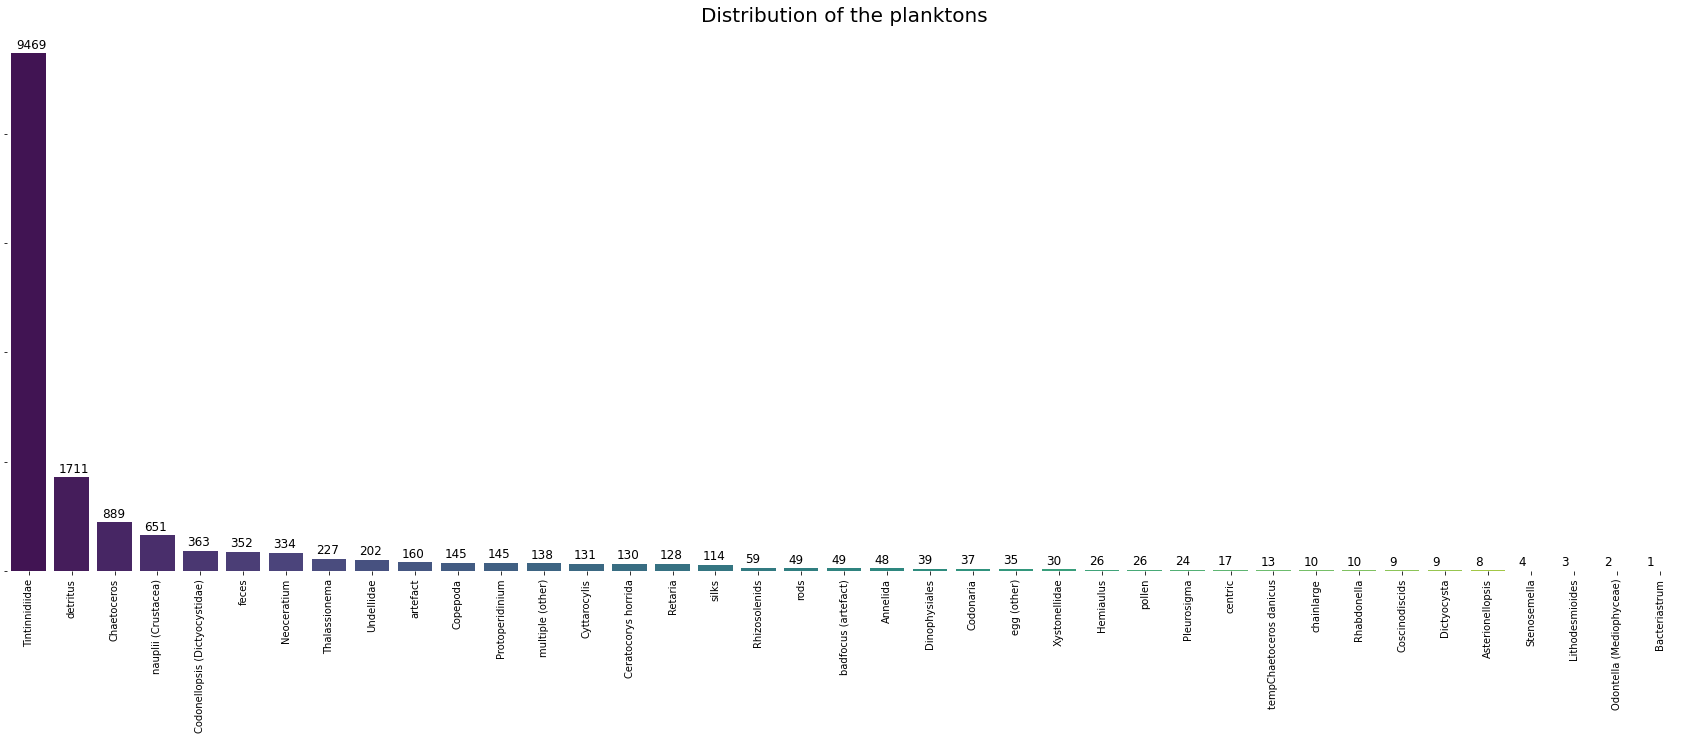

In [0]:
plt.figure(figsize=(30,10))

g = sns.countplot(train_set_reshaped.level2, order = train_set_reshaped['level2'].value_counts().index, palette='viridis')
g.set_xticklabels(train_set_reshaped.level2.unique(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of the planktons', fontsize=20)
plt.tick_params(axis='x', which='minor', labelsize=20)

for i in range(len(train_set_reshaped.level2.unique())):
    label = train_set_reshaped['level2'].value_counts()[i]
    plt.text(x = i - 0.3 , y = label+100, s = label, size = 12)

plt.show()

Thanks to this, we reduce the number of samples by keeping the same distribution of the labels. 

> Deleting the local variable to have more RAM memory...

In [0]:
del X_train
del y_train

In [0]:
del train_set_reshaped

In [0]:
del merge_X_y

### *Resizing the images*

####Resizing the images on the training set

Due to time restrictions or computational restraints, we choose to do transfer learning to save time, by working on pretrained models. 

One important aspect of these deep learning models is that they can automatically learn hierarchical feature representations. This means that *features computed by the first layer are general and can be reused in different problem domains*, while *features computed by the last layer are specific and depend on the chosen dataset and task*.

When you’re using a pre-trained model based on CNN, it’s smart to use a small learning rate because high learning rates increase the risk of losing previous knowledge. 

As we have a large dataset, but different from the pre-trained model’s dataset, our problem is a **Quadrant 1**. print(Since you have a large dataset, you’re able to train a model from scratch and do whatever you want. Despite the dataset dissimilarity, in practice, it can still be useful to initialise your model from a pre-trained model, using its architecture and weights.

After some research, the deep learning algorithm the most adapted to our problem is certainly Keras VGG16, VGG19 and InceptionV3 models.

Let's first try VGG16, the 16-layer neural network. 

We can see here the 16 layers of VGG16. It has in total 138 357 544 parameters. We can see that the input of the model must be a image of size 224x224x3, with 3 channels. 

Let's resize our images to (32x32x1) to have the same input for all images.

In [0]:
X_train_VGG16 = []
objid = X_train_reduce.values[:,0]
size = 224 

for i in range(len(objid)):
  id = objid[i]
  name = 'imgs/'+str(id)+'.jpg'
  img = Image.open(img_files[name])
  
  #Resizing to (224,224)
  img_resized=img.resize((size,size), resample=Image.NEAREST)

  #In RGB : 
  array = np.array(img_resized)
  img_resized = np.dstack((np.dstack((array,array)),array))
  X_train_VGG16.append(img_resized)

X_train_VGG16 = np.array(X_train_VGG16)

In [0]:
X_test_resized = []

for i in range (np.shape(X_test)[0]):
  final_dim = np.zeros((32, 32, 3))
  new_dim = cv2.resize(X_test[i][1], (32, 32))
  final_dim[:,:,0] = new_dim
  final_dim[:,:,1] = new_dim
  final_dim[:,:,2] = new_dim
  X_test_resized.append(final_dim)

Shape of the first image of the training set: (92, 63)


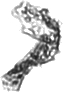

In [0]:
print('Shape of the first image of the training set:', np.shape(X_train_reduce.values[10][1]))
cv2_imshow(X_train_reduce.values[10][1])

Shape of the first image of the training set after resizing: (224, 224, 3)


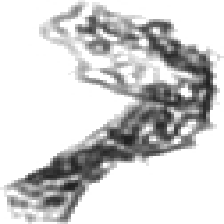

In [0]:
print('Shape of the first image of the training set after resizing:', np.shape(X_train_VGG16[10]))
cv2_imshow(X_train_VGG16[10])

In [0]:
np.save('X_train_15797.npy', X_train_VGG16)
np.save('y_train_15797.npy', y_train_reduce)

#### Resizing the images on the testing set

In [0]:
X_test = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/Separation/y_test.npy', allow_pickle=True)

In [0]:
X_test_objid = X_test[:,0]
del X_test

In [0]:
y_test_VGG16 = y_test[:22565]
print('Number of samples of the testing set:', int(len(X_test_objid)/3))

Number of samples of the testing set: 22565


In [0]:
X_test_VGG16 = []
size = 224 

for i in range(int(len(X_test_objid)/3)):
  id = X_test_objid[i]
  name = 'imgs/'+str(id)+'.jpg'
  img = Image.open(img_files[name])
  
  #Resizing to (224,224)
  img_resized=img.resize((size,size), resample=Image.NEAREST)

  #In RGB : 
  array = np.array(img_resized)
  img_resized = np.dstack((np.dstack((array,array)),array))
  X_test_VGG16.append(img_resized)

X_test_VGG16 = np.array(X_test_VGG16)

Shape of the first image of the testing set: (355, 293)


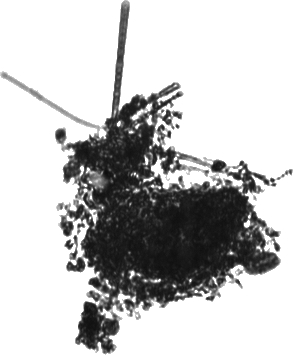

In [0]:
print('Shape of the first image of the testing set:', np.shape(X_test[0,1]))
cv2_imshow(X_test[0,1])

Shape of the first image of the testing set after resizing: (224, 224, 3)


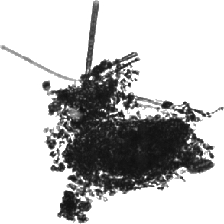

In [0]:
print('Shape of the first image of the testing set after resizing:', np.shape(X_test_VGG16[0]))
cv2_imshow(X_test_VGG16[0])

In [0]:
np.save('X_test_22565.npy', X_test_VGG16)
np.save('y_test_22565.npy', y_test_VGG16)

#### Pre-trained model: VGG16

#### Training

In [0]:
X_train_15797 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/train15797/X_train_15797.npy', allow_pickle=True)

In [0]:
y_train_15797 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/train15797/y_train_15797.npy', allow_pickle=True)
encoder = OneHotEncoder()
encoder.fit(y_train_15797.reshape(-1,1))
y_train_15797_encode = encoder.transform(y_train_15797.reshape(-1,1)).toarray()

In [0]:
print('Label of the first sample before one hot encoding:', y_train_15797[0])
print('Label of the first sample after one hot encoding:', y_train_15797_encode[0])

Label of the first sample before one hot encoding: ['Tintinnidiidae']
Label of the first sample after one hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
vggmodel = VGG16(weights='imagenet', include_top=True)
x = vggmodel.layers[-2].output
#We just add the last Dense layer
predictions = Dense(39, activation="sigmoid")(x)
vgg_model = Model(input = vggmodel.input, output = predictions)

vgg_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [0]:
def precision_score(y_true, y_pred):
  y_pred = K.round(y_pred)
  tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
  fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
  fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
  return tp / (tp + fp + K.epsilon())

def recall_score(y_true, y_pred):
  y_pred = K.round(y_pred)
  tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
  fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
  return tp / (tp + fn + K.epsilon())

def f1_score(y_true, y_pred):

    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
vgg_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=2e-3, momentum = 0.9), metrics = [f1_score, precision_score, recall_score])

In [0]:
filepath = 'weights_vgg16(f1real).hdf5'
filepath2 = 'weights_vgg16(lossreal).hdf5'
checkpoint1 = ModelCheckpoint(filepath, monitor='val_f1_score', verbose=0, save_weights_only=True,
                                                 save_best_only=True, mode='max', period=1)
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_loss', verbose=0, save_weights_only=True,
                                                 save_best_only=True, mode='min', period=1)

In [0]:
history_vgg = vgg_model.fit(X_train_15797, y_train_15797_encode, validation_split = 0.3, batch_size=16, nb_epoch=25, verbose=1, callbacks=[checkpoint1,checkpoint2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 11057 samples, validate on 4740 samples
Epoch 1/25
11057/11057 [==============================] - 106s 10ms/step - loss: 0.0481 - f1_score: 0.0395 - precision_score: 0.0416 - recall_score: 0.0401 - val_loss: 0.0371 - val_f1_score: 0.0560 - val_precision_score: 0.0584 - val_recall_score: 0.0568
Epoch 2/25
11057/11057 [==============================] - 104s 9ms/step - loss: 0.0327 - f1_score: 0.0672 - precision_score: 0.0704 - recall_score: 0.0675 - val_loss: 0.0322 - val_f1_score: 0.0726 - val_precision_score: 0.0757 - val_recall_score: 0.0731
Epoch 3/25
11057/11057 [==============================] - 104s 9ms/step - loss: 0.0269 - f1_score: 0.0856 - precision_score: 0.0888 - recall_score: 0.0857 - val_loss: 0.0300 - val_f1_score: 0.0878 - val_precision_score: 0.0914 - val_recall_score: 0.0879
Epoch 4/25
11057/11057 [==============================] - 104s 9ms/step - loss: 0.0232 - f1_score: 0.0951 - precision_score: 0.0977 - recall_score: 0.0954 - val_loss: 0.0325 - val_f1_score

In [0]:
metrics_VGG16 = vgg_model.history
loss_train = metrics_VGG16['loss']
f1_train = metrics_VGG16['f1_m']
recall_train = metrics_VGG16['recall_m']
precision_train = metrics_VGG16['precision_m']

loss_valid = metrics_VGG16['val_loss']
f1_valid = metrics_VGG16['val_f1_m']
recall_valid = metrics_VGG16['val_recall_m']
precision_valid = metrics_VGG16['val_precision_m']
epoch = [i for i in range(1,11)]

plt.plot(epoch, f1_train, '.', label = 'Training f1 score')
plt.plot(epoch, f1_valid, '.', label = 'Validation f1 score')
plt.xlabel('Epoch number')
plt.ylabel('F1 score')
plt.title('F1 score w.r.t the epoch number')
plt.legend()
plt.show()

plt.plot(recall_train, precision_train, '.', label = 'Training')
for i in range(len(epoch)):
    label = i+1
    plt.text(x = recall_train[i] - 0.009 , y = precision_train[i] + 0.001, s = label, size = 9, color = 'blue', label = 'Epoch')
plt.plot(recall_valid, precision_valid, '.', label = 'Testing')
for i in range(len(epoch)):
    label = i+1
    plt.text(x = recall_valid[i] + 0.005 , y = precision_valid[i] + 0.001, s = label, size = 9, color = 'orange', label = 'Epoch')
plt.xlabel('Recall')
plt.ylabel('Presicion')
plt.title('Precision-Recall curve (and the associated epoch number')
plt.legend()
plt.show()

plt.plot(epoch, loss, '.', label = 'Training loss')
plt.plot(epoch, loss_valid, '.', label = 'Testing loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Loss w.r.t the epoch number')
plt.legend()
plt.show()

#### Result on the testing set

In [0]:
X_test_22565 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/test22565/X_test_22565.npy', allow_pickle=True)
y_test_22565 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/test22565/y_test_22565.npy', allow_pickle=True)

In [0]:
y_test_22565_encode = np.float32(encoder.transform(y_test_22565.reshape(-1,1)).toarray())

In [0]:
vgg16_model = VGG16(weights='imagenet', include_top=True)
x = vgg16_model.layers[-2].output
predictions = Dense(39, activation="sigmoid")(x)
vgg16_model = Model(input = vgg16_model.input, output = predictions)
vgg16_model.load_weights('/content/drive/My Drive/Plankton Recognition Challenge/Irina/weights_vgg16(f1).hdf5')

553467904/553467096 [==============================] - 12s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [0]:
start_time = time.time()
y_predict_vgg16 = vgg_model.predict(X_test_22565)
print("--- %s seconds ---" % (time.time() - start_time))

--- 58.51248097419739 seconds ---


In [0]:
np.save('y_predict_vgg16.npy', y_predict_vgg16)

In [0]:
print(y_predict_vgg16[0])
print(y_test_22565_encode[0])

[6.7844186e-03 4.3093524e-07 5.0041587e-07 1.0453918e-07 6.5481886e-06
 5.6193237e-08 3.0517845e-07 8.5351703e-06 1.8574617e-08 1.6143517e-11
 1.2967815e-08 1.4986819e-07 3.8588682e-06 1.4864945e-06 3.9720550e-08
 3.2601528e-07 8.6589671e-07 1.0283202e-09 7.4440341e-06 6.9881858e-06
 5.5058972e-08 6.6364926e-08 7.8841931e-06 9.9720558e-07 2.4216639e-11
 5.1966849e-09 2.7836675e-06 8.0483625e-07 2.0109862e-08 8.3387232e-07
 5.6235981e-01 7.2163992e-08 5.6810170e-01 5.2941651e-03 3.9201640e-03
 4.4995200e-08 5.0811644e-07 2.0374231e-10 1.5859101e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
final_y_predict_vgg16 = []

for i in range (np.shape(y_predict_vgg16)[0]):
  label = np.zeros(39)
  indice = np.argmax(y_predict_vgg16[i])
  label[indice] = 1
  final_y_predict_vgg16.append(label)

In [0]:
print('Recall on the testing set', recall_score(y_test_22565_encode, final_y_predict_vgg16, average='macro'))
print('Precision on the testing set', precision_score(y_test_22565_encode, final_y_predict_vgg16, average='macro'))
print('f1 score on the testing set', f1_score(y_test_22565_encode, final_y_predict_vgg16, average='macro'))

Recall on the testing set 0.39838615115504444
Precision on the testing set 0.5192105243070881
f1 score on the testing set 0.43440773503619795


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test1: f1_score_valid = , f1_score_test = 35,85%, SGD, lr = 2e-3, momentum=0.9, epoch = 10, batch_size = 32

Test2: f1_score_valid = 0 , SGD, lr = 1e-1, momentum=0.9, epoch = 1, batch_size = 32

Test3: f1_score_valid = 0.0189, f1_score_test = 1,93%, Adam, lr=0.01, epoch = 1, batch_size = 32

Test4: f1_score_valid = 0.0481, f1_score_test = 10.91%, SGD, lr=000001, momentum = 0.9, epoch = 20, batch_size = 32

Test5: f1_score_valid = 0.1361, f1_score_test = %, SGD, lr=5e-3, momentum = 0.9, epoch = 20, batch_size = 32

Test6: f1_score_valid = 0.1323, f1_score_test = 39,86%, SGD, lr=3e-3, momentum = 0.9, epoch = 13, batch_size = 32

Test7: f1_score_valid = 0.1354, f1_score_test = 35.65%, SGD, lr=3e-3, momentum = 0,6, epoch = 13, batch_size = 32

Test8: f1_score_valid = 0.0968, f1_score_test = 43,44%, SGD, lr=2e-3, momentum = 0,9, epoch = 25, batch_size = 16

# III. Merging the results

We obtained different classification results with different algorithms. Some models are based on the features, others on the images. Thus, merging the results can be very interesting as the results are not obtained thanks to the same data. Some mistakes done by a neural network can be done by another NN (as they both work on the same data: the images), but can give another result with an algorithm using the features. 

That is why we are going to merge the outputs of these algorihtms : 

- Random Forest (f1_score: **42%**): it gives, for each sample, a 0 vector with a unique 1, that corresponds to the final classification.  

- LeNet5 (f1_score: **38%**): it gives, for each sample, the probability that the sample belongs to a given class.

- VGG16 (f1_score: **43%**): it gives, for each sample, the probability that the sample belongs to a given class.

The idea is now to sum these outputs with different weights depending on the result of the model: the more the model performs well, the more the weight will be high. 

## 4.a. Merging the results

In [0]:
# Download y train to get the encoder

y_train_15797 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/train15797/y_train_15797.npy', allow_pickle=True)
encoder = OneHotEncoder()
encoder.fit(y_train_15797.reshape(-1,1))
y_train_15797_encode = encoder.transform(y_train_15797.reshape(-1,1)).toarray()

In [0]:
y_pred_rf = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Irina/y_predict_RandomForest.npy', allow_pickle=True)
y_pred_lenet5 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Irina/proba labels using lenet 5 sigmoid.npy', allow_pickle=True)
y_pred_vgg16 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Irina/y_pred_vgg16.npy', allow_pickle=True)

y_test_22565 = np.load('/content/drive/My Drive/Plankton Recognition Challenge/Data/test22565/y_test_22565.npy', allow_pickle=True)
y_test_22565_encode = np.float32(encoder.transform(y_test_22565.reshape(-1,1)).toarray())

In [0]:
y_pred_rf_binary = []
y_pred_lenet5_binary = []
y_pred_vgg16_binary = []

for i in range (np.shape(y_test_22565)[0]):

  label_rf = np.zeros(39)
  label_rf[np.argmax(y_pred_rf[i])] = 1
  y_pred_rf_binary.append(label_rf)

  label_lenet5 = np.zeros(39)
  label_lenet5[np.argmax(y_pred_lenet5[i])] = 1
  y_pred_lenet5_binary.append(label_lenet5)

  label_vgg16 = np.zeros(39)
  label_vgg16[np.argmax(y_pred_vgg16[i])] = 1
  y_pred_vgg16_binary.append(label_vgg16)

In [0]:
print('f1 score Random Forest', f1_score(y_test_22565_encode, y_pred_rf_binary, average='macro'))
print('f1 score LeNet5', f1_score(y_test_22565_encode, y_pred_lenet5_binary, average='macro'))
print('f1 score VGG16', f1_score(y_test_22565_encode, y_pred_vgg16_binary, average='macro'))

f1 score Random Forest 0.4196282699985913
f1 score LeNet5 0.3777664662638372
f1 score VGG16 0.43440773503619795


In [0]:
max_proba_vgg16 = []
max_proba_lenet5 = []
max_proba_rf = []

for i in range(np.shape(y_pred_vgg16)[0]):
  max_proba_vgg16.append(max(y_pred_vgg16[i])) 
  max_proba_lenet5.append(max(y_pred_lenet5[i])) 
  max_proba_rf.append(max(y_pred_rf[i])) 

mean_vgg16 = np.mean(max_proba_vgg16)
mean_lenet5 = np.mean(max_proba_lenet5)
mean_rf = np.mean(max_proba_rf)

In [0]:
print('Mean of the highest proba of a sample is', mean_vgg16, 'for VGG16')
print('Mean of the highest proba of a sample is', mean_lenet5, 'for LeNet5')
print('Mean of the highest proba of a sample is', mean_rf, 'for Random Forest')

Mean of the highest proba of a sample is 0.8965198 for VGG16
Mean of the highest proba of a sample is 0.38674757 for LeNet5
Mean of the highest proba of a sample is 1.0 for Random Forest


In [0]:
def cont_to_binary(y):
  y_binary = []
  for i in range (np.shape(y)[0]):
    label = np.zeros(39)
    label[np.argmax(y[i])] = 1
    y_binary.append(label)
  return y_binary

list_alpha = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
list_beta = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
list_gamma = [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
f1_max = 0 
best_param = [0,0,0]

for i in range(len(list_alpha)):
  alpha = list_alpha[i]
  for j in range(len(list_beta)):
    beta = list_beta[j]
    for k in range(len(list_gamma)):
      gamma = list_gamma[k]
      y_pred_temp = alpha*y_pred_rf + beta*y_pred_lenet5 + gamma*y_pred_vgg16
      f1_score_temp = sklearn.metrics.f1_score(y_test_22565_encode, cont_to_binary(y_pred_temp), average='macro')
      if f1_score_temp > f1_max:
        f1_max = f1_score_temp
        best_param = [alpha, beta, gamma]

In [0]:
print('Best parameters:', best_param)
y_pred_merge = best_param[0]*y_pred_rf + best_param[1]*y_pred_lenet5 + best_param[2]* y_pred_vgg16
y_pred_merge_binary = cont_to_binary(y_pred_merge)
print('f1 score on the testing set:', f1_score(y_test_22565_encode, y_pred_merge_binary, average='macro'))
print('Precision on the testing set:', precision_score(y_test_22565_encode, y_pred_merge_binary, average='macro'))
print('Recall on the testing set:', recall_score(y_test_22565_encode, y_pred_merge_binary, average='macro'))
print('Accuracy on the testing set:', accuracy_score(y_test_22565_encode, y_pred_merge_binary))

Best parameters: [1, 4, 2.2]
f1 score on the testing set: 0.4471001838354843
Precision on the testing set: 0.6408254913952477


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall on the testing set: 0.39901180478050724
Accuracy on the testing set: 0.8214934633281631


## 4.b. Visualize the results

In [0]:
y_pred_decoded = encoder.inverse_transform(y_pred_merge_binary)

In [0]:
columns = ['level2']
y_pred_pd = pd.DataFrame(y_pred_decoded)
y_pred_pd.columns = columns

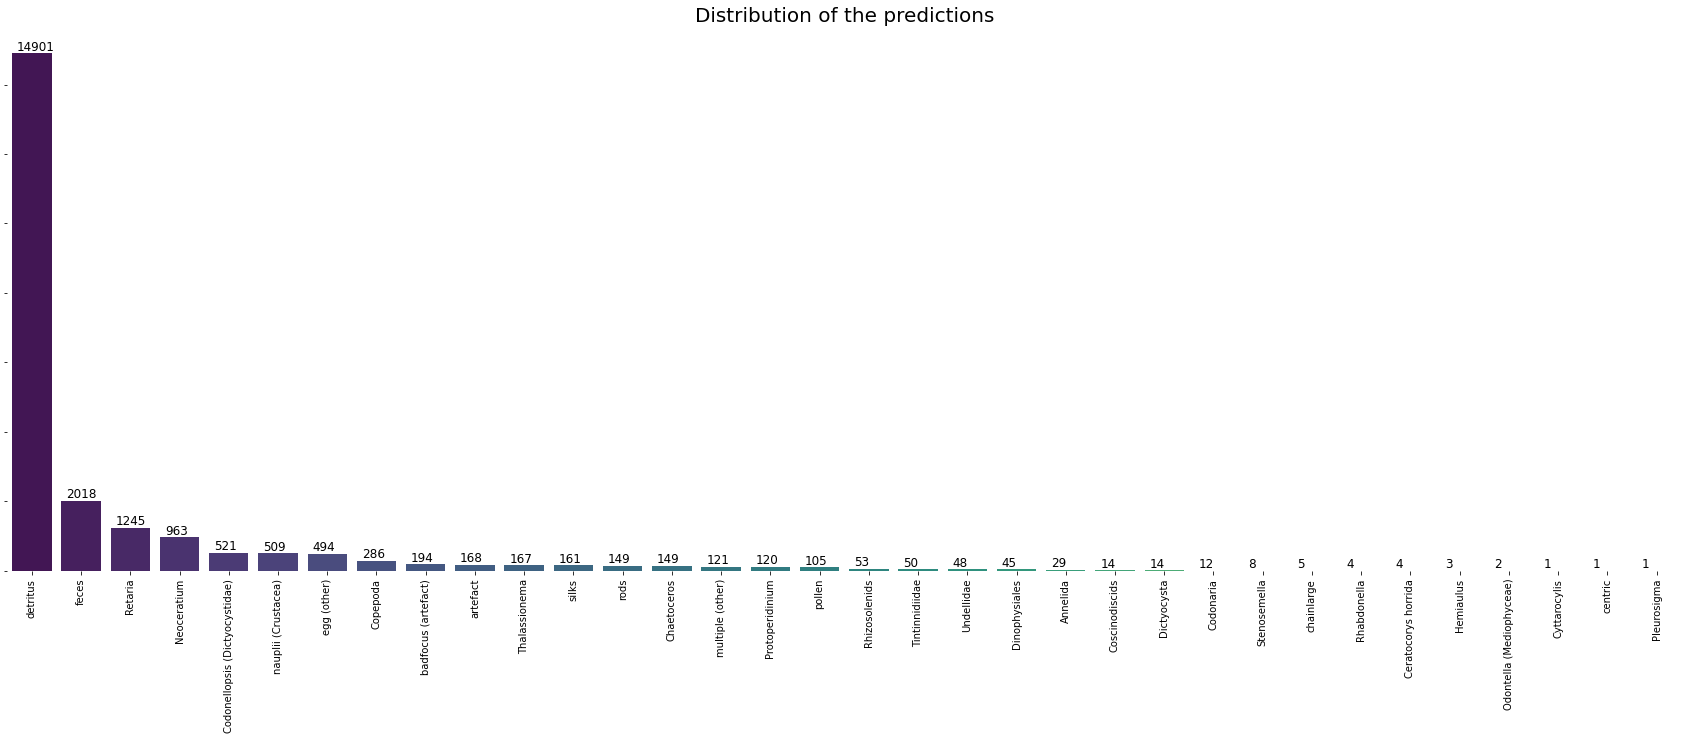

In [0]:
plt.figure(figsize=(30,10))

g = sns.countplot(y_pred_pd.level2, order = y_pred_pd['level2'].value_counts().index, palette='viridis')
g.set_xticklabels(y_pred_pd.level2.unique(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of the predictions', fontsize=20)
plt.tick_params(axis='x', which='minor', labelsize=20)

for i in range(len(y_pred_pd.level2.unique())):
    label = y_pred_pd['level2'].value_counts()[i]
    plt.text(x = i - 0.3 , y = label+100, s = label, size = 12)

plt.show()

In [0]:
columns = ['level2']
y_test_pd = pd.DataFrame(y_test_22565)
y_test_pd.columns = columns

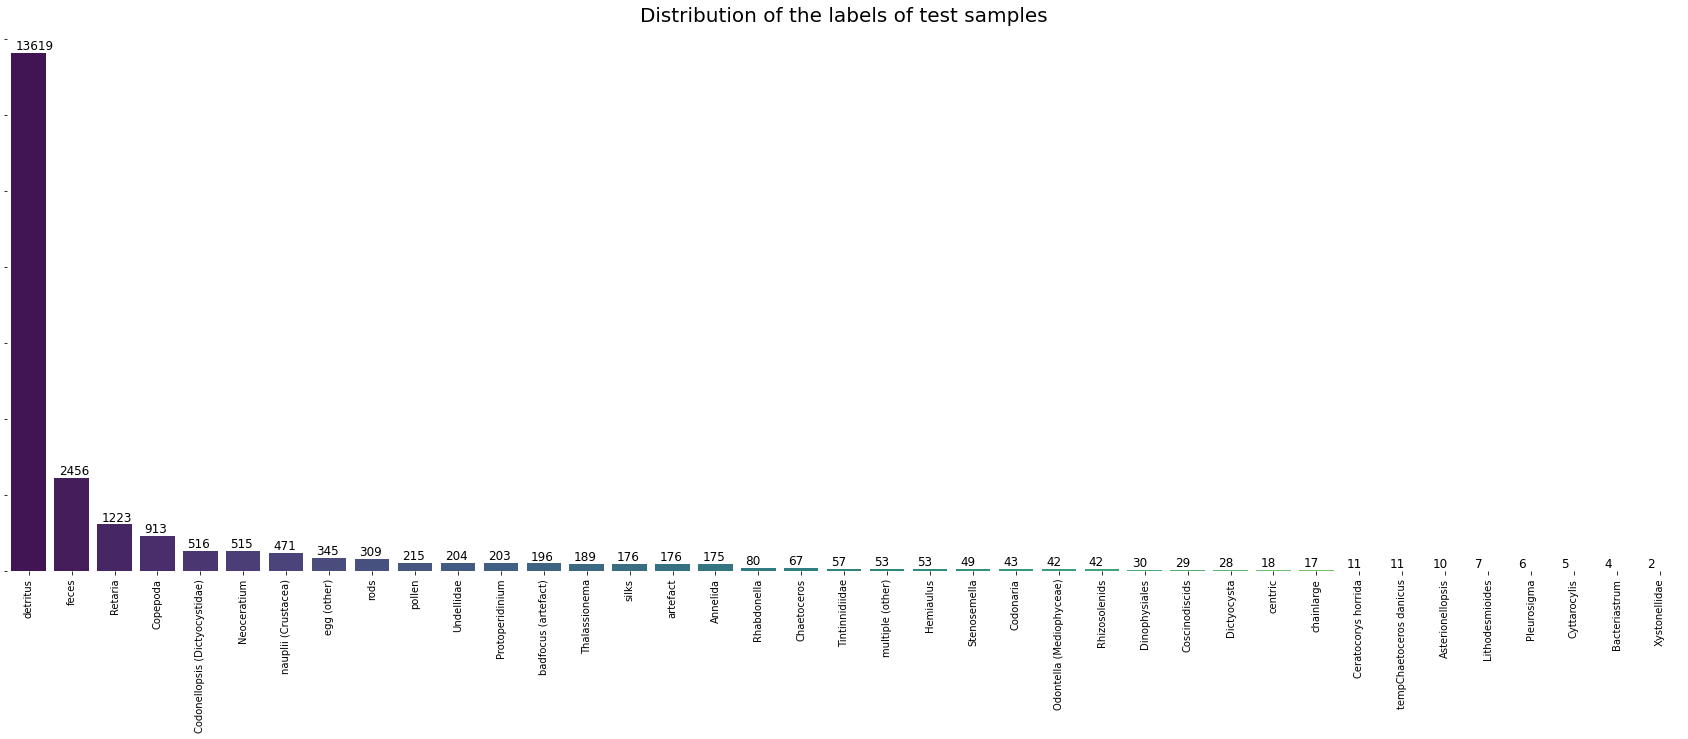

In [0]:
plt.figure(figsize=(30,10))

g = sns.countplot(y_test_pd.level2, order = y_test_pd['level2'].value_counts().index, palette='viridis')
g.set_xticklabels(y_test_pd.level2.unique(), rotation=90)
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of the labels of test samples', fontsize=20)
plt.tick_params(axis='x', which='minor', labelsize=20)

for i in range(len(y_test_pd.level2.unique())):
    label = y_test_pd['level2'].value_counts()[i]
    plt.text(x = i - 0.3 , y = label+100, s = label, size = 12)

plt.show()

To see how the samples have been predicted, let's plot a **normalized confusion matrix** (and not only a confusion matrix since as the detritus is very dominant, the matrix won't be useful). 

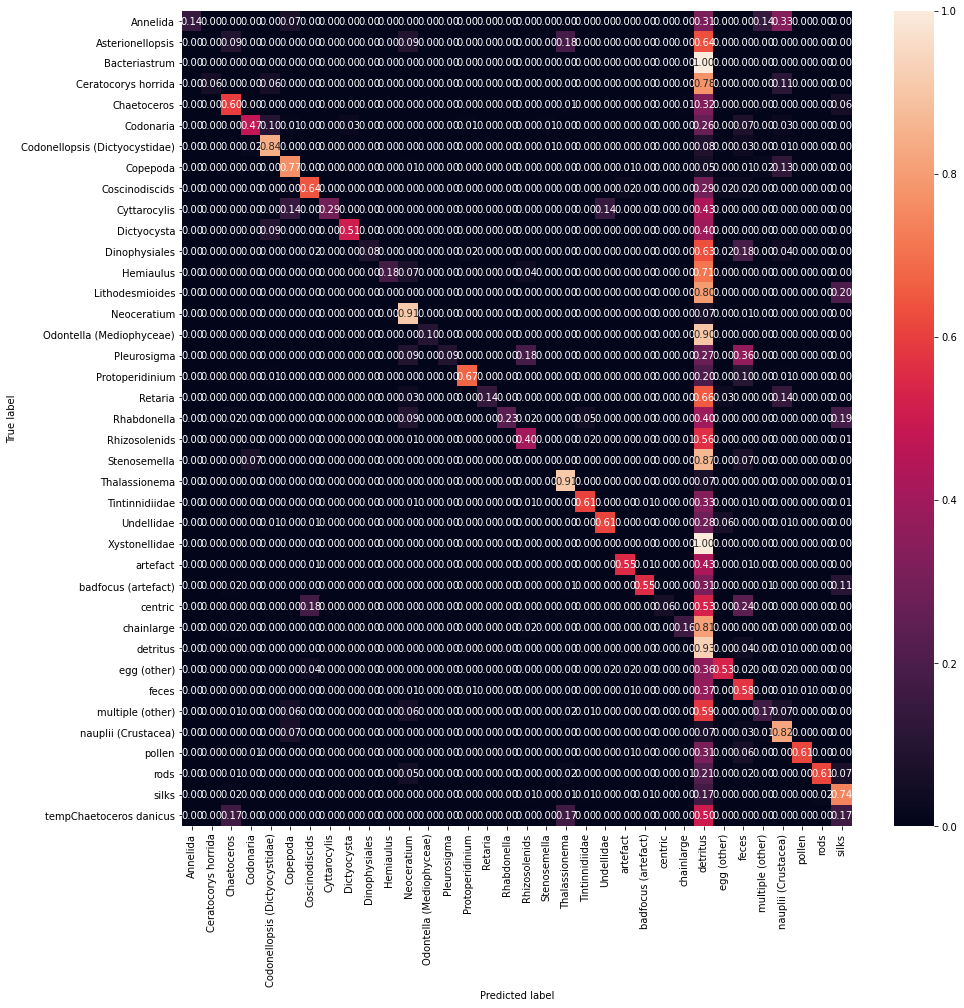

In [0]:
columns = ['True label','Predicted label']

results_pd = pd.concat([pd.DataFrame(y_test_22565),pd.DataFrame(y_pred_decoded)],axis=1)
results_pd.columns = columns
confusion_matrix = pd.crosstab(results_pd['True label'], results_pd['Predicted label'], rownames=['True label'], colnames=['Predicted label'])
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
plt.show()

We can see thanks to this normalized confusion matrix that all classes have been globally pretty well predicted (the diagonal is visible). The 'detritus' class, for example, is well labeled 94% of time.

However, we can also see the vertical line of above the 'detritus' label, meaning that a lot of samples have this wrong predicted label. For example, the 'Xystonellidae' or 'Bacteriastrum' samples have **always** been predicted like a 'detritus' (coefficient of 1). The unbalanced distribution of our training set can explain this phenomenon: the models tend to overfit on the 'detritus' class, and 'forgot' the other classes.

## 4.c. Top3 Top5 accuracies

In [0]:
# Compute top3 or top5 vector

def top(n, y_pred_merge):
  top_n = []
  for i in range(np.shape(y_pred_merge)[0]):
    pred = np.copy(y_pred_merge[i])
    topn_i = np.zeros(39)

    max1 = np.argmax(pred)
    topn_i[max1] = 1
    pred[max1] = 0

    max2 = np.argmax(pred)
    topn_i[max2] = 1
    pred[max2] = 0

    max3 = np.argmax(pred)
    topn_i[max3] = 1
    pred[max3] = 0

    if n == 3:
      top_n.append(topn_i)

    if n == 5 : 
      max4 = np.argmax(pred)
      topn_i[max4] = 1
      pred[max4] = 0

      max5 = np.argmax(pred)
      topn_i[max5] = 1
      pred[max5] = 0

      top_n.append(topn_i)

  return top_n

In [0]:
top3 = top(3, y_pred_merge)
top5 = top(5, y_pred_merge)

In [0]:
top3_pred_bool = np.array(top3, dtype=bool)
top5_pred_bool = np.array(top5, dtype=bool)
y_test_bool = np.array(y_test_22565_encode, dtype=bool)

and_top3 = top3_pred_bool & y_test_bool     # logical AND
and_top5 = top5_pred_bool & y_test_bool     # logical AND


compt_top3 = 0
compt_top5 = 0
for i in range(np.shape(y_test_bool)[0]):
  if True in and_top3[i]:
    compt_top3 +=1
  if True in and_top5[i]:
    compt_top5 +=1

print('The top 1 accuracy is equal to', accuracy_score(y_test_22565_encode, y_pred_merge_binary))
print('The top 3 accuracy is equal to', compt_top3/np.shape(y_test_bool)[0])
print('The top 5 accuracy is equal to', compt_top5/np.shape(y_test_bool)[0])

The top 1 accuracy is equal to 0.8214934633281631
The top 3 accuracy is equal to 0.9632616884555728
The top 5 accuracy is equal to 0.9833370263682695
